### DRAFT VERSION: final version to be supplied

# Project 1: MTA WMWY subway turnstile analysis

**Program:** mta_women_tech_gala_final_JBM.ipynb <br>
**Date:** Jan 4-10, 2021

**Description** Analyze MTA and Census data to make recommendations on where to deploy canvasers <br>
**Created by:** Josh Banks Mailman, Chuck Cao, Humza Khan, Chris Chan <br>

**Joshua Mailman specific code, as explained below** <br>

**Listing of sections to be supplied**


# 0. Importing libraries

In [176]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import datetime
import seaborn as sb
%matplotlib inline

# 1. Reading in data

This next cell is legacy code from before we captured multiple weeks at a time

In [177]:
# turnstile_data_source = 'http://web.mta.info/developers/data/nyct/turnstile/'  
# turnstile_filename1 = 'turnstile_190713.txt'
# df = pd.read_csv(turnstile_data_source + '/' + turnstile_filename1)

After step 2 below, using just a single week's worth of data, I suggested that teammates could write code to load and process multiple weeks at a time, so that we could more easily work with all of it. Teammate Chris Chan then supplied the code in the cell below.

In [178]:
#initialise the number of weeks for the dataset
num_weeks = 4

#initialise the date for the first week of the dataset (week ending on start_date)
start_date = filedate = pd.Timestamp('2019-05-04 00:00:00')

#initialise the regex for the MTA turnstile url
filename_regex = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"

filelist = []

for numfiles in range (num_weeks):
    # create the appropriate filename for the week
    filedate_str = str(filedate.year)[2:4] + str(filedate.month).zfill(2) + str(filedate.day).zfill(2)
    filename = filename_regex.format(filedate_str)

    # read the file and append it to the list of files to be concacated
    #df = pd.read_csv(filename, parse_dates=['DATE'], keep_date_col=True)  
    df = pd.read_csv(filename, keep_date_col=True)
    filelist.append(df)

    # advance to the next week
    filedate += pd.Timedelta(days=7)
df = pd.concat(filelist, axis=0, ignore_index=True)

# 2. Preliminary steps:
* ### Assessment of the shape and content of the data, including possible trends to pursue
* ### Reshaping of data
* ### Limited data cleaning and wrangling
### NOTE: This entire _preliminary steps_ section could be skipped over in order to get to the actual data analysis that follows in section 3

In [179]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [180]:
# rename columns since the last column, 'EXITS', contains trailing whitespace
df.columns = df.columns.str.replace(r'\s+', '')

# convert to numeric to enable computation
df["EXITS"] = pd.to_numeric(df["EXITS"])
df["ENTRIES"] = pd.to_numeric(df["ENTRIES"])

******
#### New code to convert date and time strings to data and time datatypes, and then generate a composed datetime column

In [181]:
df['Datetime'] = pd.to_datetime(df.DATE + df.TIME, format='%m/%d/%Y%H:%M:%S')

New code that makes a dictionary for days-of-week as number to days of week as words.
Then generate a new column that provides days of any date given.

In [182]:
# We'll now get days of the week instead at a later step, rather than here
# days_of_week = {0: 'Monday', 1:'Tuesday', 2:'Wednesday',3:'Thursday',4:'Friday', 5:'Saturday', 6:'Sunday'}
# df['Day_of_week'] = [days_of_week[datetime.datetime.weekday(date)] for date in df['Datetime']]
# df.sample(10)

Trying to groupby to get counter-runs isolated

In [183]:
df['Traffic_running_total']=df['ENTRIES']+df['EXITS']

In [185]:
# Use domain knowledge to select subway stops in and near the Flatiron district where there are many tech companies
df_23st = df[df['STATION'].str.contains('23 ST')]

# Four subway stops either in or near the Flatiron district
flatiron = df_23st[df_23st['LINENAME'].str.contains('NRW')]
gramercy = df_23st[df_23st['LINENAME'].str.contains('6')]
east_chelsea = df_23st[df_23st['LINENAME'].str.contains('F')]
union_sq = df[df['STATION'].str.contains('14 ST-UNION SQ')]

Examine exits at different times in at the FI stop.

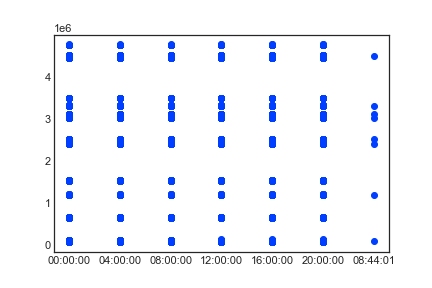

In [186]:
plt.scatter(x=flatiron['TIME'], y=(flatiron['EXITS']).astype(int))

This is not very helpful because times are in four-hour increments. 

To verify, let's sample the data and look at the TIME column: 16, 12, 0, 8, etc.

In [187]:
flatiron.sample(200)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Traffic_running_total
4189,A030,R083,01-06-01,23 ST,NRW,BMT,04/30/2019,04:00:00,REGULAR,85796044,1184865,2019-04-30 04:00:00,86980909
623673,A030,R083,01-00-02,23 ST,NRW,BMT,05/24/2019,08:00:00,REGULAR,5166424,2409721,2019-05-24 08:00:00,7576145
415031,A030,R083,01-03-00,23 ST,NRW,BMT,05/11/2019,08:00:00,REGULAR,6445980,3108264,2019-05-11 08:00:00,9554244
623892,A031,R083,00-00-00,23 ST,NRW,BMT,05/18/2019,20:00:00,REGULAR,1230217,662816,2019-05-18 20:00:00,1893033
211063,A031,R083,00-00-00,23 ST,NRW,BMT,05/09/2019,08:00:00,REGULAR,1207211,650539,2019-05-09 08:00:00,1857750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4064,A030,R083,01-03-01,23 ST,NRW,BMT,04/30/2019,08:00:00,REGULAR,9837340,3021907,2019-04-30 08:00:00,12859247
210777,A030,R083,01-00-02,23 ST,NRW,BMT,05/04/2019,16:00:00,REGULAR,5145279,2401130,2019-05-04 16:00:00,7546409
4326,A031,R083,00-00-02,23 ST,NRW,BMT,05/02/2019,00:00:00,REGULAR,6508438,3487152,2019-05-02 00:00:00,9995590
211270,A031,R083,00-03-02,23 ST,NRW,BMT,05/08/2019,20:00:00,REGULAR,79948,101830,2019-05-08 20:00:00,181778


In [188]:
flatiron[flatiron["C/A"]=="A030"].shape

(1352, 13)

In [189]:
flatiron[flatiron["C/A"]=="A031"].shape

(1008, 13)

In [190]:
flatiron[flatiron["UNIT"]=="R083"].shape

(2360, 13)

In [191]:
252+336

588

In [192]:
flatiron[flatiron["UNIT"]=="R083"].tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Traffic_running_total
624134,A031,R083,00-03-02,23 ST,NRW,BMT,05/24/2019,04:00:00,REGULAR,101129,127566,2019-05-24 04:00:00,228695
624135,A031,R083,00-03-02,23 ST,NRW,BMT,05/24/2019,08:00:00,REGULAR,101168,127759,2019-05-24 08:00:00,228927
624136,A031,R083,00-03-02,23 ST,NRW,BMT,05/24/2019,12:00:00,REGULAR,101354,128385,2019-05-24 12:00:00,229739
624137,A031,R083,00-03-02,23 ST,NRW,BMT,05/24/2019,16:00:00,REGULAR,101784,128745,2019-05-24 16:00:00,230529
624138,A031,R083,00-03-02,23 ST,NRW,BMT,05/24/2019,20:00:00,REGULAR,102234,129022,2019-05-24 20:00:00,231256


Could do a groupby to aggregate the average or sum of entries at each time of day.

In [194]:
What about by days of the week?

Object `week` not found.


In [ ]:
What about by days of the week

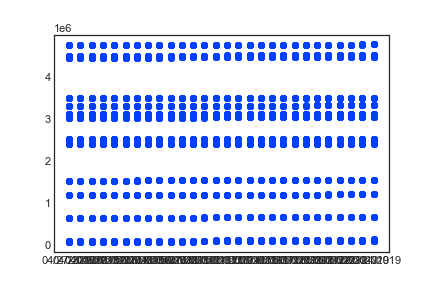

In [195]:
plt.scatter(x=flatiron['DATE'], y=(flatiron['EXITS']).astype(int))

I don't think I understand yet what the 'EXITS' column really means yet.  Even within the same week at the same time interval 

there are many datapoints.

To go further, we probably need to review the 'codebook' for this dataset. Otherwise we can end up with a garbage-in analysis

### Diary and communication to teammates about issues encountered
**In-the-trenches diary and communication to teammates regarding an initial approach for advancing the analysis** (This approach was somewhat superseded by a more refined one.)

I've figured out the issue here. The entries and exits columns are actually cumulative counts for each specific counting device. Therefore to extract the data we need, we need to is the following:
0. Convert ENTRIES and EXITS columns to integers so we can compute their numerical diff
1. Convert it into a list of dataframes where each dataframe in the list corresponds to a counting device. (To do this we first extract the unique values in the device column; then cycle through that list, using each item to extract rows matching it.
2. Then cycle through each data frame in our list of dataframes
    * sort it by TIME just to be on the safe side
    * create two new columns that contains the difference between each row's ENTRY and EXIT counts and that of the previous row
3. Append each of dataframe in the result list into a one list
4. Sort by date and time to find graph these to discover days and times with highest traffic
5. might use a calendar library ot convert date to day of week and do groupby on that
6. could also graph traffic against TIME, while ignorning day
7. Ideally we could drill down and find the day-of-week and time that consistently have the highest traffic during the summer. This would require the above pipeline for multiple weeks and multiple years, and pooling that data.

Unfortunately the "Field description" actually doesn't explain which column corresponds to the counting device. Is it `C/A` or it it `Unit`? 

In [196]:
flatiron.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Traffic_running_total
3876,A030,R083,01-00-00,23 ST,NRW,BMT,04/27/2019,00:00:00,REGULAR,53384,65840,2019-04-27 00:00:00,119224
3877,A030,R083,01-00-00,23 ST,NRW,BMT,04/27/2019,04:00:00,REGULAR,53384,65846,2019-04-27 04:00:00,119230
3878,A030,R083,01-00-00,23 ST,NRW,BMT,04/27/2019,08:00:00,REGULAR,53384,65899,2019-04-27 08:00:00,119283
3879,A030,R083,01-00-00,23 ST,NRW,BMT,04/27/2019,12:00:00,REGULAR,53384,66056,2019-04-27 12:00:00,119440
3880,A030,R083,01-00-00,23 ST,NRW,BMT,04/27/2019,16:00:00,REGULAR,53384,66332,2019-04-27 16:00:00,119716


Let's see how many rows are in a single `C/A` and `UNIT`

In [197]:
flatiron[flatiron["C/A"]=="A030"].shape

(1352, 13)

In [198]:
flatiron[flatiron["C/A"]=="A031"].shape

(1008, 13)

In [199]:
flatiron[flatiron["UNIT"]=="R083"].shape

(2360, 13)

Let's look at the seam between `C/A` == A030 and and A031, to see if the cumulative count restarts.

In [200]:
flatiron[flatiron["UNIT"]=="R083"].iloc[330:340]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Traffic_running_total
4206,A030,R083,01-06-01,23 ST,NRW,BMT,05/03/2019,00:00:00,REGULAR,85800727,1187022,2019-05-03 00:00:00,86987749
4207,A030,R083,01-06-01,23 ST,NRW,BMT,05/03/2019,04:00:00,REGULAR,85800731,1187028,2019-05-03 04:00:00,86987759
4208,A030,R083,01-06-01,23 ST,NRW,BMT,05/03/2019,08:00:00,REGULAR,85800754,1187069,2019-05-03 08:00:00,86987823
4209,A030,R083,01-06-01,23 ST,NRW,BMT,05/03/2019,12:00:00,REGULAR,85800948,1187349,2019-05-03 12:00:00,86988297
4210,A030,R083,01-06-01,23 ST,NRW,BMT,05/03/2019,16:00:00,REGULAR,85801293,1187522,2019-05-03 16:00:00,86988815
4211,A030,R083,01-06-01,23 ST,NRW,BMT,05/03/2019,20:00:00,REGULAR,85801938,1187690,2019-05-03 20:00:00,86989628
4212,A031,R083,00-00-00,23 ST,NRW,BMT,04/27/2019,00:00:00,REGULAR,1179235,636328,2019-04-27 00:00:00,1815563
4213,A031,R083,00-00-00,23 ST,NRW,BMT,04/27/2019,04:00:00,REGULAR,1179322,636343,2019-04-27 04:00:00,1815665
4214,A031,R083,00-00-00,23 ST,NRW,BMT,04/27/2019,08:00:00,REGULAR,1179341,636374,2019-04-27 08:00:00,1815715
4215,A031,R083,00-00-00,23 ST,NRW,BMT,04/27/2019,12:00:00,REGULAR,1179547,636507,2019-04-27 12:00:00,1816054


Indeed, the counting in `EXITS` jumps from 1230536 to 714199 at the seam from A030 to A031, so it seems that the C/A column contains the device label.

Looking further, however, what about the SCP colomn? Let's observe what happens to the EXITS column when SCP shifts.

In [201]:
flatiron[flatiron["UNIT"]=="R083"].iloc[375:380]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Traffic_running_total
4251,A031,R083,00-00-00,23 ST,NRW,BMT,05/03/2019,12:00:00,REGULAR,1193990,644191,2019-05-03 12:00:00,1838181
4252,A031,R083,00-00-00,23 ST,NRW,BMT,05/03/2019,16:00:00,REGULAR,1194616,644476,2019-05-03 16:00:00,1839092
4253,A031,R083,00-00-00,23 ST,NRW,BMT,05/03/2019,20:00:00,REGULAR,1195814,644748,2019-05-03 20:00:00,1840562
4254,A031,R083,00-00-01,23 ST,NRW,BMT,04/27/2019,00:00:00,REGULAR,4560149,1526809,2019-04-27 00:00:00,6086958
4255,A031,R083,00-00-01,23 ST,NRW,BMT,04/27/2019,04:00:00,REGULAR,4560201,1526816,2019-04-27 04:00:00,6087017


Whoops. When SCP changes, the EXITS counts start again. So actually the combination of the C/A and SCP columns seem to 
define a counting stream

#### Try out a graph using the data from just one device

If this pans out, we'll go back and do this data cleaning at an earlier stage so it affects the entire dataset

In [266]:
FI_device_A031zeroSCP = flatiron[ (flatiron["C/A"]=="A031") & (flatiron["SCP"]=="00-00-00")].copy()
FI_device_A031zeroSCP.sort_values(by=["DATE", "TIME"]).head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Traffic_running_total
4212,A031,R083,00-00-00,23 ST,NRW,BMT,04/27/2019,00:00:00,REGULAR,1179235,636328,2019-04-27 00:00:00,1815563
4213,A031,R083,00-00-00,23 ST,NRW,BMT,04/27/2019,04:00:00,REGULAR,1179322,636343,2019-04-27 04:00:00,1815665
4214,A031,R083,00-00-00,23 ST,NRW,BMT,04/27/2019,08:00:00,REGULAR,1179341,636374,2019-04-27 08:00:00,1815715
4215,A031,R083,00-00-00,23 ST,NRW,BMT,04/27/2019,12:00:00,REGULAR,1179547,636507,2019-04-27 12:00:00,1816054
4216,A031,R083,00-00-00,23 ST,NRW,BMT,04/27/2019,16:00:00,REGULAR,1180147,636763,2019-04-27 16:00:00,1816910


In [203]:
FI_device_A031zeroSCP["Exit diffs"] = FI_device_A031zeroSCP["EXITS"].diff()

In [265]:
FI_device_A031zeroSCP[FI_device_A031zeroSCP["TIME"]=="00:00:00"].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Traffic_running_total,Exit diffs
4212,A031,R083,00-00-00,23 ST,NRW,BMT,04/27/2019,00:00:00,REGULAR,1179235,636328,2019-04-27,1815563,NaN
4218,A031,R083,00-00-00,23 ST,NRW,BMT,04/28/2019,00:00:00,REGULAR,1180990,637037,2019-04-28,1818027,104.0
4224,A031,R083,00-00-00,23 ST,NRW,BMT,04/29/2019,00:00:00,REGULAR,1182213,637470,2019-04-29,1819683,35.0
4230,A031,R083,00-00-00,23 ST,NRW,BMT,04/30/2019,00:00:00,REGULAR,1184916,638817,2019-04-30,1823733,39.0
4236,A031,R083,00-00-00,23 ST,NRW,BMT,05/01/2019,00:00:00,REGULAR,1187768,640292,2019-05-01,1828060,67.0


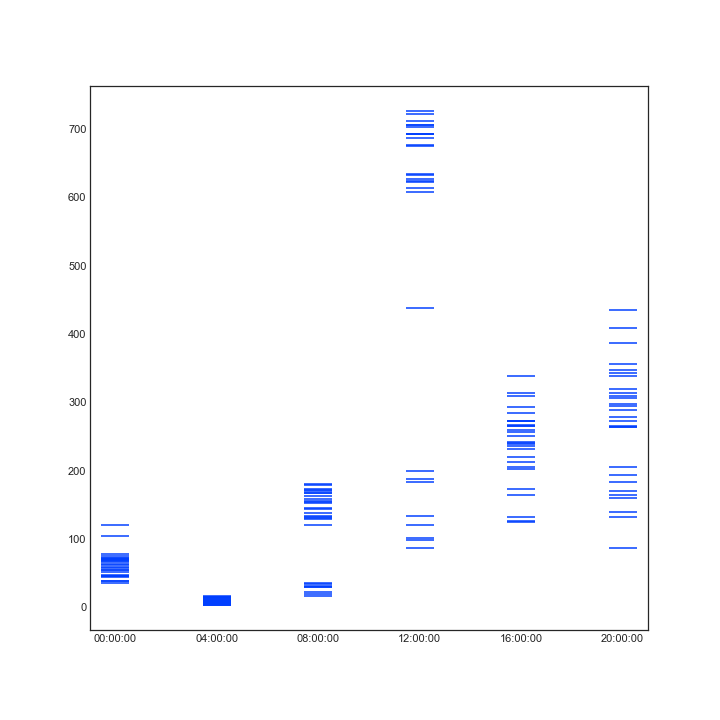

In [205]:
plt.figure(figsize=(10,10))
plt.scatter( x=FI_device_A031zeroSCP['TIME'], y=FI_device_A031zeroSCP['Exit diffs'], marker='_', s=(800,))

In [206]:
#### It seems as though **_8am-12 noon_** time (at least on certain days) as well as **_4pm-8pm_** are the times with the most traffic.

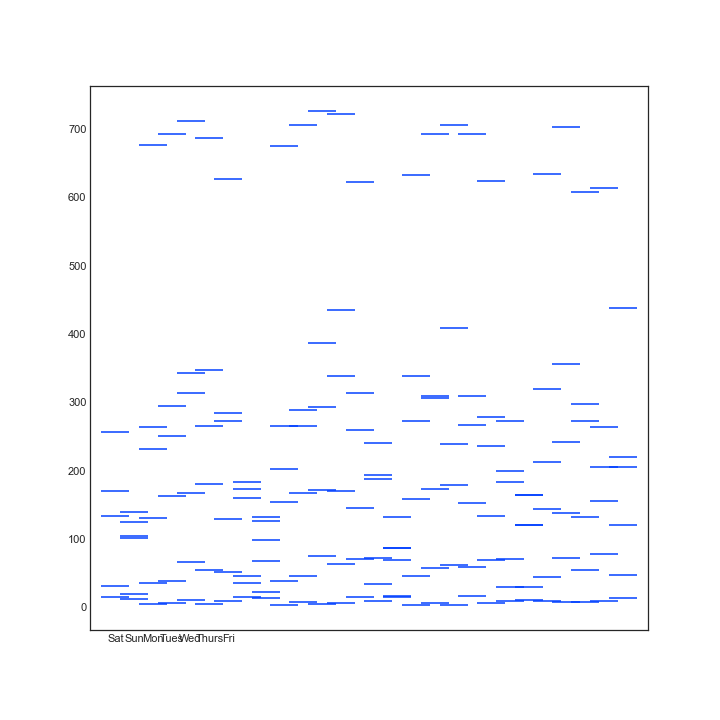

In [207]:
x_labels = ['Sat', 'Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri'] 
plt.figure(figsize=(10,10))
positions = range(7)
plt.xticks(positions, x_labels)
plt.scatter( x=FI_device_A031zeroSCP['DATE'], y=FI_device_A031zeroSCP['Exit diffs'], marker='_', s=(800,))

In [208]:
#### It seems as though Wednesday and Thursday have the most traffic.

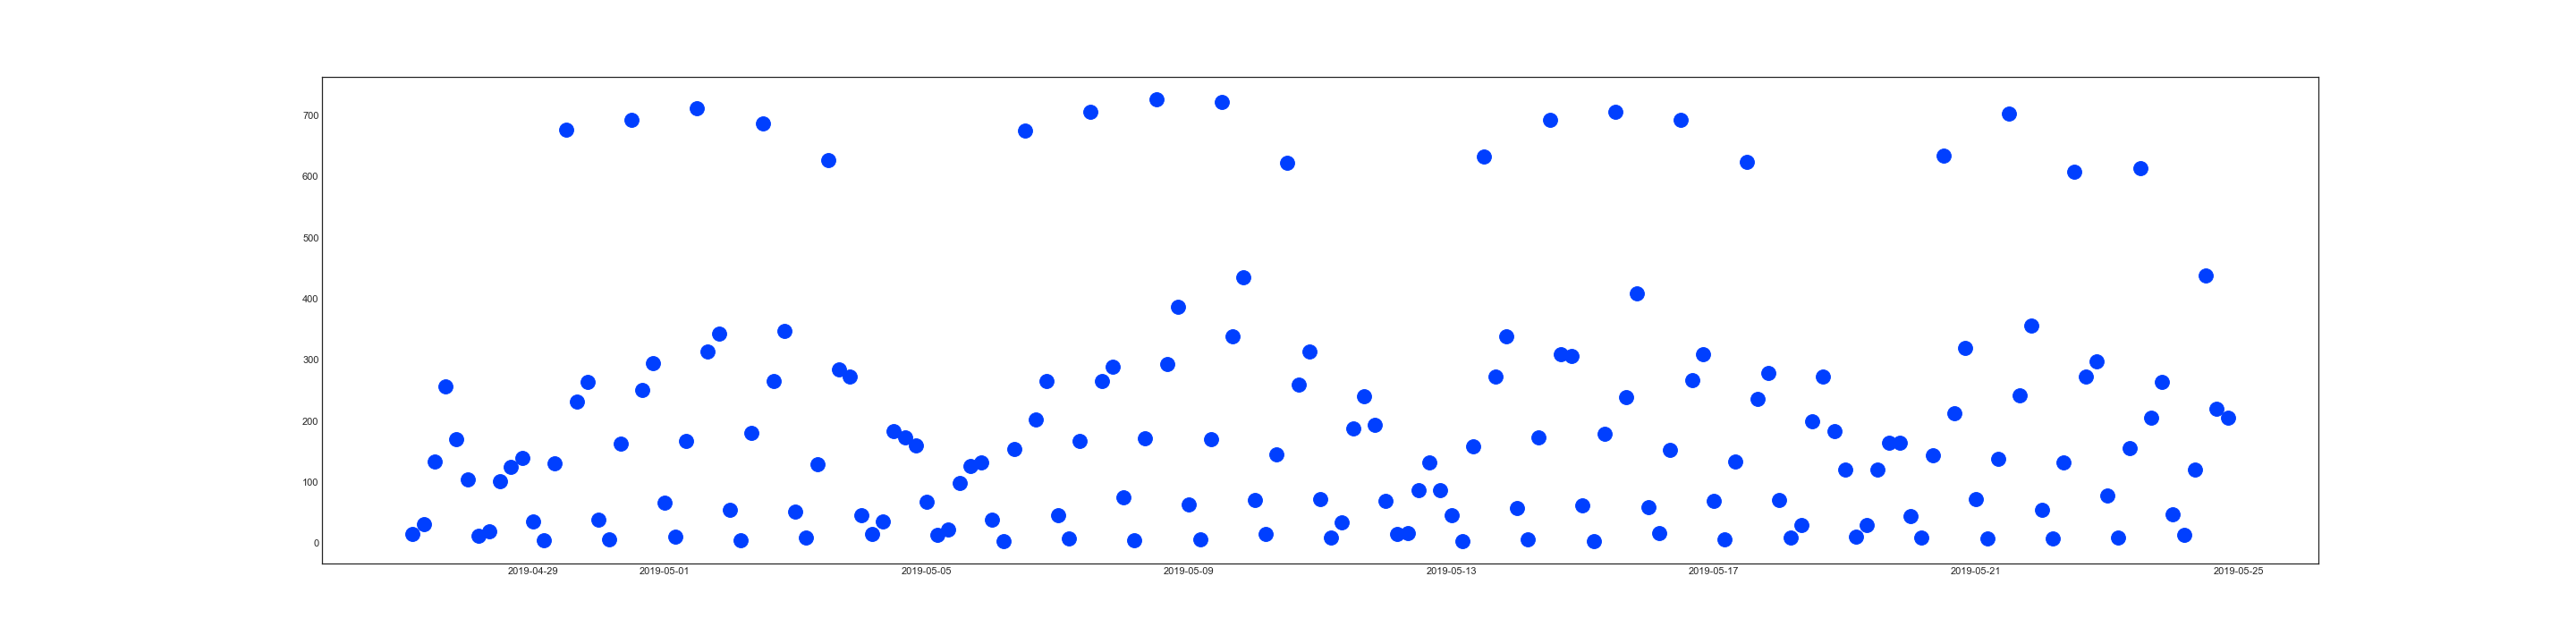

In [209]:

plt.figure(figsize=(40,10))

plt.scatter( x=FI_device_A031zeroSCP['Datetime'], y=FI_device_A031zeroSCP['Exit diffs'], marker='.', s=(1000,))


In [210]:
time_series = FI_device_A031zeroSCP.set_index('Datetime')['Exit diffs']

In [211]:
import matplotlib.dates as mdates
sns.set(rc={'figure.figsize':(40, 10)})

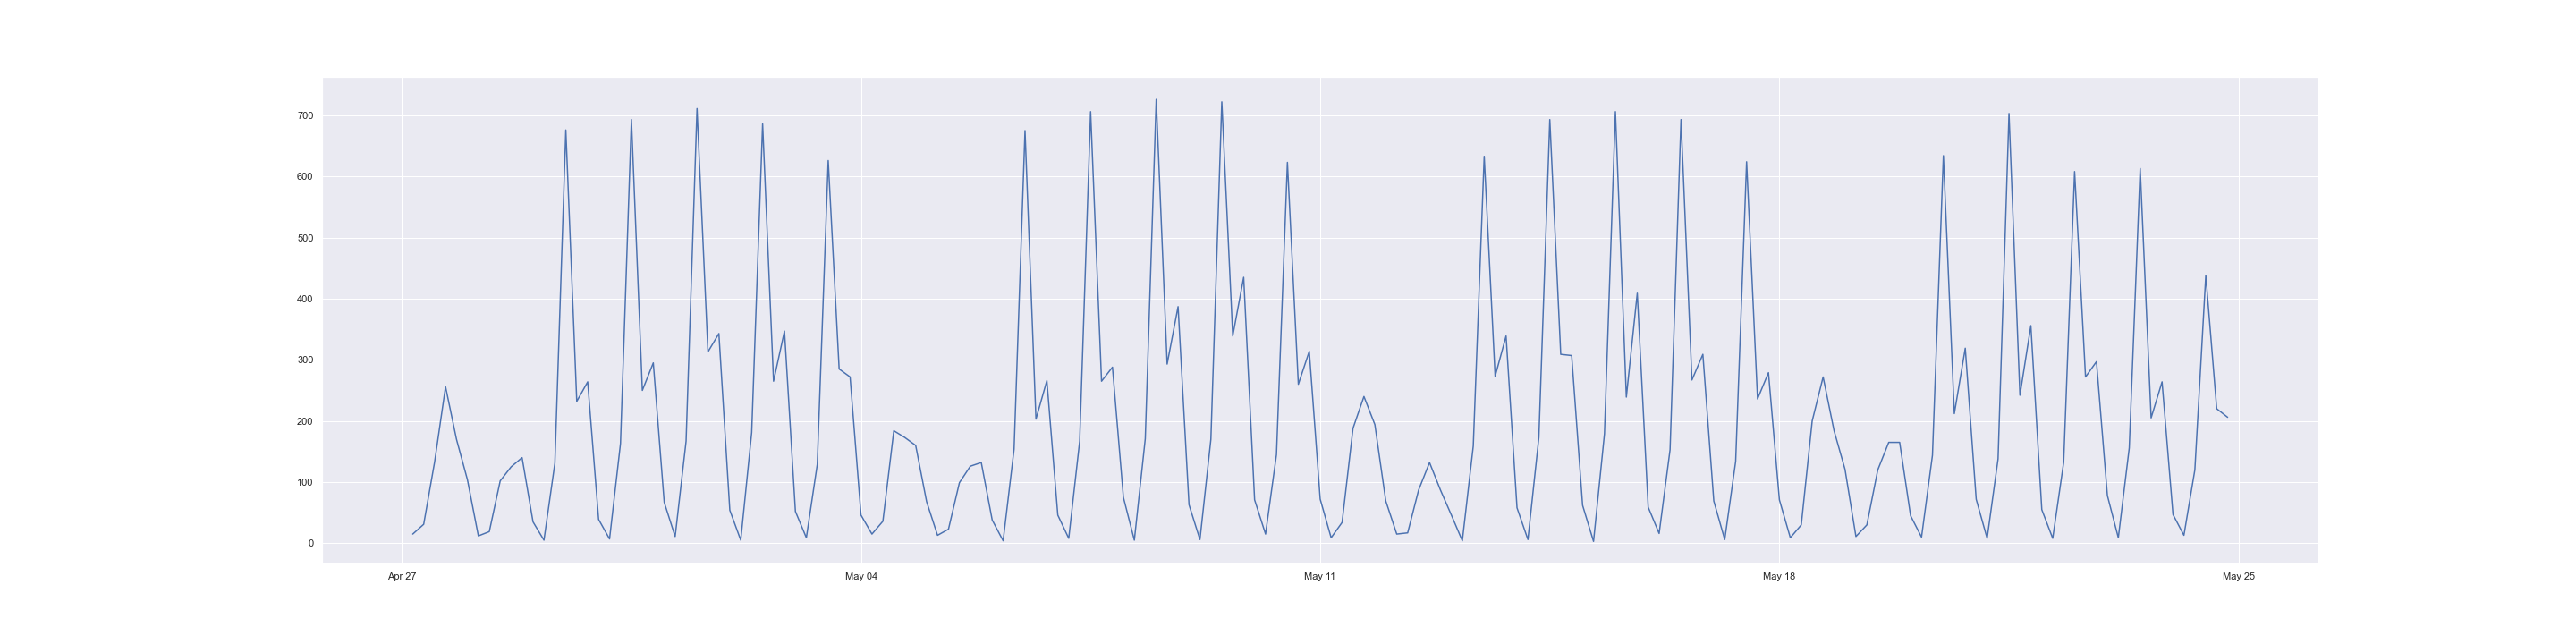

In [212]:
fig, ax = plt.subplots()
ax.plot(time_series)
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SATURDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

## 3. Reshaping data for subsequent analysis

Since `EXITS` and `ENTRIES` are cumulative within each counter-run, and the counter-runs are defined uniquely by six columns, we need to group by these, and then use a `grp.shift` method to generate a new column that computes the difference between the current row and the previous row's cumulative count, but only for rows within the same group.

In [213]:
# creating DF: grouping by unique turnstile and date to remove dups
turnstiles_4hourly = (df.groupby(["C/A", "UNIT", "SCP", "STATION","LINENAME","Datetime"],as_index=False)).Traffic_running_total.first()

In [214]:
turnstiles_4hourly.shape

(822985, 7)

In [215]:
turnstiles_4hourly.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,Datetime,Traffic_running_total
0,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 00:00:00,9420082
1,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 04:00:00,9420109
2,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 08:00:00,9420167
3,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 12:00:00,9420343
4,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 16:00:00,9420671
5,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 20:00:00,9421000
6,A002,R051,02-00-00,59 ST,NQR456W,2019-04-28 00:00:00,9421187
7,A002,R051,02-00-00,59 ST,NQR456W,2019-04-28 04:00:00,9421207
8,A002,R051,02-00-00,59 ST,NQR456W,2019-04-28 08:00:00,9421228
9,A002,R051,02-00-00,59 ST,NQR456W,2019-04-28 12:00:00,9421352


In [216]:
# apply shift of datetime and running total to compute the diff in running total traffic

turnstiles_4hourly[["PREV_TIME", "PREV_Traffic_running_total"]] = (turnstiles_4hourly
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION","LINENAME"])["Datetime", "Traffic_running_total"]
                                                       .apply(lambda grp: grp.shift(1)))

<ipython-input-216-ad3698a25527>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_4hourly[["PREV_TIME", "PREV_Traffic_running_total"]] = (turnstiles_4hourly


In [217]:
turnstiles_4hourly.iloc[40:45]

,C/A,UNIT,SCP,STATION,LINENAME,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total
40,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 11:40:35,9430606,2019-05-03 10:10:25,9430514.0
41,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 12:00:00,9430628,2019-05-03 11:40:35,9430606.0
42,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 16:00:00,9431034,2019-05-03 12:00:00,9430628.0
43,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 20:00:00,9431880,2019-05-03 16:00:00,9431034.0
44,A002,R051,02-00-00,59 ST,NQR456W,2019-05-04 00:00:00,9432168,2019-05-03 20:00:00,9431880.0


In [218]:
# create separate hour var
turnstiles_4hourly["Hour"]=pd.to_datetime(turnstiles_4hourly['Datetime']).dt.hour

In [219]:
# compute traffic per hour
turnstiles_4hourly["Delta_hours"]=pd.to_datetime(turnstiles_4hourly['Datetime']).dt.hour - pd.to_datetime(turnstiles_4hourly['PREV_TIME']).dt.hour
turnstiles_4hourly["People_per_hour"] = (turnstiles_4hourly["Traffic_running_total"] - turnstiles_4hourly["PREV_Traffic_running_total"])/turnstiles_4hourly["Delta_hours"]

In [220]:
turnstiles_4hourly.iloc[40:45]

,C/A,UNIT,SCP,STATION,LINENAME,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total,Hour,Delta_hours,People_per_hour
40,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 11:40:35,9430606,2019-05-03 10:10:25,9430514.0,11,1.0,92.0
41,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 12:00:00,9430628,2019-05-03 11:40:35,9430606.0,12,1.0,22.0
42,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 16:00:00,9431034,2019-05-03 12:00:00,9430628.0,16,4.0,101.5
43,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 20:00:00,9431880,2019-05-03 16:00:00,9431034.0,20,4.0,211.5
44,A002,R051,02-00-00,59 ST,NQR456W,2019-05-04 00:00:00,9432168,2019-05-03 20:00:00,9431880.0,0,-20.0,-14.4


In [221]:
# based on datetime, create numeric and str days of week vars
days_of_week = {0: 'Monday', 1:'Tuesday', 2:'Wednesday',3:'Thursday',4:'Friday', 5:'Saturday', 6:'Sunday'}
turnstiles_4hourly['Day_num'] = [datetime.datetime.weekday(date) for date in turnstiles_4hourly['Datetime']]
turnstiles_4hourly['Day_of_week'] = [days_of_week[datetime.datetime.weekday(date)] for date in turnstiles_4hourly['Datetime']]

In [222]:
turnstiles_4hourly.iloc[40:45]

,C/A,UNIT,SCP,STATION,LINENAME,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total,Hour,Delta_hours,People_per_hour,Day_num,Day_of_week
40,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 11:40:35,9430606,2019-05-03 10:10:25,9430514.0,11,1.0,92.0,4,Friday
41,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 12:00:00,9430628,2019-05-03 11:40:35,9430606.0,12,1.0,22.0,4,Friday
42,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 16:00:00,9431034,2019-05-03 12:00:00,9430628.0,16,4.0,101.5,4,Friday
43,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 20:00:00,9431880,2019-05-03 16:00:00,9431034.0,20,4.0,211.5,4,Friday
44,A002,R051,02-00-00,59 ST,NQR456W,2019-05-04 00:00:00,9432168,2019-05-03 20:00:00,9431880.0,0,-20.0,-14.4,5,Saturday


Create a column that indicates time by fractions of a day; it combines days and hours so that hourly (or four-hourly) data is analyzed across the entire week span.

In [223]:
turnstiles_4hourly["Day_hour"]= turnstiles_4hourly["Day_num"] + (turnstiles_4hourly["Hour"])/24
turnstiles_4hourly.iloc[40:45]

,C/A,UNIT,SCP,STATION,LINENAME,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total,Hour,Delta_hours,People_per_hour,Day_num,Day_of_week,Day_hour
40,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 11:40:35,9430606,2019-05-03 10:10:25,9430514.0,11,1.0,92.0,4,Friday,4.458333
41,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 12:00:00,9430628,2019-05-03 11:40:35,9430606.0,12,1.0,22.0,4,Friday,4.500000
42,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 16:00:00,9431034,2019-05-03 12:00:00,9430628.0,16,4.0,101.5,4,Friday,4.666667
43,A002,R051,02-00-00,59 ST,NQR456W,2019-05-03 20:00:00,9431880,2019-05-03 16:00:00,9431034.0,20,4.0,211.5,4,Friday,4.833333
44,A002,R051,02-00-00,59 ST,NQR456W,2019-05-04 00:00:00,9432168,2019-05-03 20:00:00,9431880.0,0,-20.0,-14.4,5,Saturday,5.000000


## 4. Characterizing the location of subway stations 
**Merging (joining) with the MTA's stations data set to exploit data pertaining to the location of stations, such as median household income**

What about the zip code of stations? We'll need to merge this with the turnstile data if we want to 

identify stops that that are higher-income neighborhoods, by joining (merging) with a demographics/census dataset

In [224]:
stations = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')

In [225]:
stations.sample(10)

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes
294,294,294,103,IRT,Broadway - 7Av,238 St,Bx,1,Elevated,40.884667,-73.900870,242 St,Manhattan,0,NaN
81,82,82,J14,BMT,Jamaica,104 St,Q,J Z,Elevated,40.695178,-73.844330,Jamaica,Manhattan,0,NaN
460,460,460,716,IRT,Flushing,33 St-Rawson St,Q,7,Elevated,40.744587,-73.930997,Flushing,Manhattan,0,NaN
26,27,617,R31,BMT,4th Av,Atlantic Av-Barclays Ctr,Bk,D N R,Subway,40.683666,-73.978810,Manhattan,Coney Island - Bay Ridge,1,NaN
401,401,612,630,IRT,Lexington Av,51 St,M,6,Subway,40.757107,-73.971920,Uptown & The Bronx,Downtown,1,NaN
139,141,141,S03,BMT,Franklin Shuttle,Park Pl,Bk,S,Open Cut,40.674772,-73.957624,Franklin Av,Prospect Park,1,NaN
275,275,612,F11,IND,Queens Blvd,Lexington Av/53 St,M,E M,Subway,40.757552,-73.969055,Queens,Downtown & Brooklyn,1,NaN
446,446,446,505,IRT,Dyre Av,Morris Park,Bx,5,Open Cut,40.854364,-73.860495,Eastchester - Dyre Av,Manhattan,0,NaN
311,311,311,121,IRT,Broadway - 7Av,86 St,M,1,Subway,40.788644,-73.976218,Uptown & The Bronx,Downtown,0,NaN
300,300,300,110,IRT,Broadway - 7Av,191 St,M,1,Subway,40.855225,-73.929412,Uptown & The Bronx,Downtown,0,NaN


Whereas the stop names in the turnstile dataset were all caps, these are in title case. 

Who knows if truly corresponding names are used for each station?

As a preliminary step to finding out, lets convert that columns to upper 

In [226]:
stations['Stop Name'] = stations['Stop Name'].str.upper() 

In [227]:
# sanity check
stations.sample(5)

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes
407,407,407,636,IRT,Lexington Av,ASTOR PL,M,6,Subway,40.730054,-73.991070,Uptown & The Bronx,Downtown,0,NaN
193,193,193,A63,IND,Liberty Av,104 ST,Q,A,Elevated,40.681711,-73.837683,Manhattan,Lefferts Blvd,0,NaN
331,331,624,228,IRT,Clark St,PARK PLACE,M,2 3,Subway,40.713051,-74.008811,Uptown & The Bronx,Downtown & Brooklyn,0,NaN
312,312,312,122,IRT,Broadway - 7Av,79 ST,M,1,Subway,40.783934,-73.979917,Uptown & The Bronx,Downtown,0,NaN
389,389,604,414,IRT,Jerome Av,161 ST-YANKEE STADIUM,Bx,4,Elevated,40.827994,-73.925831,Woodlawn,Manhattan,1,NaN


In [228]:
stations.columns

Index(['Station ID', 'Complex ID', 'GTFS Stop ID', 'Division', 'Line',
       'Stop Name', 'Borough', 'Daytime Routes', 'Structure', 'GTFS Latitude',
       'GTFS Longitude', 'North Direction Label', 'South Direction Label',
       'ADA', 'ADA Notes'],
      dtype='object')

In [229]:
stations.shape

(496, 15)

# 5. Analysis of household income data and linking to station complexes 
The section is primarily the work of teammate **Chris Chan**. To bring in analysis of income data, I suggested to Chris we use zip code to exploit the uszipcodes API. 
I helped him debug certain aspects of using this API, afterwhich he developed the code in this section, which connects subway stations to income levels in the neighborhood.**

## -------- CC - Adding Income Data to Stations by Lat/Lng --------
1. import uszipcode package
2. use lat/lng function to pull median hh income from database

#### Other potentially useful variables from the zipcode list:
zipcode_type='Standard', <br>
major_city='Derwood', <br>
county='Montgomery County', <br>
state='MD', <br>
radius_in_miles=4.0, <br>
population=14295, <br>
population_density=1090.0, <br>
housing_units=5018, <br>
occupied_housing_units=4889,  <br>
median_home_value=453900, <br>
median_household_income=120603

#### Other interesting metrics from this data can be found here: https://pypi.org/project/uszipcode/

In [230]:
### uszip method
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=False)

In [231]:
def getincome(_lat,_lon):
    income = search.by_coordinates(_lat,_lon, radius=2,returns=1)[0].median_household_income
    return income

In [232]:
stations['income'] = stations.apply(lambda row:  getincome(row['GTFS Latitude'], row['GTFS Longitude']) ,axis=1)                                              

In [233]:
stations.shape

(496, 16)

In [234]:
# check if income is in df
stations.head()

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes,income
0,1,1,R01,BMT,Astoria,ASTORIA-DITMARS BLVD,Q,N W,Elevated,40.775036,-73.912034,NaN,Manhattan,0,NaN,57525.0
1,2,2,R03,BMT,Astoria,ASTORIA BLVD,Q,N W,Elevated,40.770258,-73.917843,Ditmars Blvd,Manhattan,1,NaN,49924.0
2,3,3,R04,BMT,Astoria,30 AV,Q,N W,Elevated,40.766779,-73.921479,Astoria - Ditmars Blvd,Manhattan,0,NaN,49924.0
3,4,4,R05,BMT,Astoria,BROADWAY,Q,N W,Elevated,40.761820,-73.925508,Astoria - Ditmars Blvd,Manhattan,0,NaN,49924.0
4,5,5,R06,BMT,Astoria,36 AV,Q,N W,Elevated,40.756804,-73.929575,Astoria - Ditmars Blvd,Manhattan,0,NaN,48720.0


In [235]:
print(" \nCount total NaN at each column in a Station : \n\n", stations.isnull().sum(), "# row/cols",stations.shape)

 
Count total NaN at each column in a Station : 

 Station ID                 0
Complex ID                 0
GTFS Stop ID               0
Division                   0
Line                       0
Stop Name                  0
Borough                    0
Daytime Routes             0
Structure                  0
GTFS Latitude              0
GTFS Longitude             0
North Direction Label     18
South Direction Label     15
ADA                        0
ADA Notes                487
income                    31
dtype: int64 # row/cols (496, 16)


In [236]:
print(stations[stations['income'].isna()]) 

     Station ID  Complex ID GTFS Stop ID Division                 Line  \
7             8           8          R13      BMT              Astoria   
8             9           9          R14      BMT  Broadway - Brighton   
9            10          10          R15      BMT  Broadway - Brighton   
10           11         611          R16      BMT  Broadway - Brighton   
17           18         623          R23      BMT             Broadway   
18           19         623          Q01      BMT     Manhattan Bridge   
20           21         624          R25      BMT             Broadway   
103         104         623          M20      BMT              Jamaica   
104         105         622          M21      BMT              Jamaica   
105         106         628          M22      BMT              Jamaica   
106         107         107          M23      BMT              Jamaica   
163         164         164          A28      IND   8th Av - Fulton St   
172         172         628          A

In [237]:
lat=40.764811 
lon=-73.973347

result = search.by_coordinates(lat=lat,lng=lon, radius=5,returns=1)[0].median_household_income    

### We may have to either impute these values separately with the income from the nearest station (i.e. widen the radius)

## --------- CC - END OF INCOME MERGE ----------

## --------- CC - Read in xwalk for booth to stations data ---------
(downloaded from: https://qri.cloud/nyc-transit-data/remote_complex_lookupcsv)

There is no direct link between the stations df and the turnstile df. Therefore we found a link using complex_id from stations and complex_id from xwalk. The xwalk contains C/A, Unit, Station, Line to merge with the turnstile data

You need to have the .csv file saved in the location of the program

In [238]:
station_xwalk = pd.read_csv('booth_station_xwalk.csv')

In [239]:
station_xwalk.head()

,remote,booth,complex_id,station,line_name,division
0,R001,A060,635.0,WHITEHALL ST,R1,BMT
1,R001,A058,635.0,WHITEHALL ST,R1,BMT
2,R001,R101S,635.0,SOUTH FERRY,R1,IRT
3,R002,A077,628.0,FULTON ST,ACJZ2345,BMT
4,R002,A081,628.0,FULTON ST,ACJZ2345,BMT


In [240]:
# complex id is float64 but needs to convert to int. Can only do by filling the nans with 0 first
import numpy as np
station_xwalk['complex_id2'] = station_xwalk['complex_id'].fillna(0,inplace=True)
station_xwalk['complex_id2'] = station_xwalk['complex_id'].apply(np.int64)

In [241]:
station_xwalk.head()

,remote,booth,complex_id,station,line_name,division,complex_id2
0,R001,A060,635.0,WHITEHALL ST,R1,BMT,635
1,R001,A058,635.0,WHITEHALL ST,R1,BMT,635
2,R001,R101S,635.0,SOUTH FERRY,R1,IRT,635
3,R002,A077,628.0,FULTON ST,ACJZ2345,BMT,628
4,R002,A081,628.0,FULTON ST,ACJZ2345,BMT,628


In [242]:
# merge xwalk to stations by complex id
stations_complex = stations.merge(station_xwalk[["remote","booth","station","complex_id2"]], left_on="Complex ID", right_on="complex_id2")

In [243]:
stations_complex.shape

(1011, 20)

In [244]:
test=stations_complex["complex_id2"]==635
test1=stations_complex[test]

In [245]:
test1.head(20)

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes,income,remote,booth,station,complex_id2
193,23,635,R27,BMT,Broadway,WHITEHALL ST-SOUTH FERRY,M,R W,Subway,40.703087,-74.012994,Uptown & Queens,Brooklyn,0,NaN,119274.0,R001,A060,WHITEHALL ST,635
194,23,635,R27,BMT,Broadway,WHITEHALL ST-SOUTH FERRY,M,R W,Subway,40.703087,-74.012994,Uptown & Queens,Brooklyn,0,NaN,119274.0,R001,A058,WHITEHALL ST,635
195,23,635,R27,BMT,Broadway,WHITEHALL ST-SOUTH FERRY,M,R W,Subway,40.703087,-74.012994,Uptown & Queens,Brooklyn,0,NaN,119274.0,R001,R101S,SOUTH FERRY,635
196,330,635,142,IRT,Broadway - 7Av,SOUTH FERRY,M,1,Subway,40.702068,-74.013664,Uptown & The Bronx,NaN,1,NaN,129313.0,R001,A060,WHITEHALL ST,635
197,330,635,142,IRT,Broadway - 7Av,SOUTH FERRY,M,1,Subway,40.702068,-74.013664,Uptown & The Bronx,NaN,1,NaN,129313.0,R001,A058,WHITEHALL ST,635
198,330,635,142,IRT,Broadway - 7Av,SOUTH FERRY,M,1,Subway,40.702068,-74.013664,Uptown & The Bronx,NaN,1,NaN,129313.0,R001,R101S,SOUTH FERRY,635


In [246]:
stations_complex.columns

Index(['Station ID', 'Complex ID', 'GTFS Stop ID', 'Division', 'Line',
       'Stop Name', 'Borough', 'Daytime Routes', 'Structure', 'GTFS Latitude',
       'GTFS Longitude', 'North Direction Label', 'South Direction Label',
       'ADA', 'ADA Notes', 'income', 'remote', 'booth', 'station',
       'complex_id2'],
      dtype='object')

In [247]:
# get unique level stations/ complex data by REMOTE field which will merge back to Turnstile
#stations_complex_inc = stations_complex.groupby(['remote'])['income'].mean().reset_index()

In [248]:
# get unique level stations/ complex data by REMOTE field which will merge back to Turnstile

#stations_complex2 = stations_complex.groupby(['remote']).agg({'income':'mean'}).reset_index()
#stations_complex2 = stations_complex.groupby(['remote'])['income','GTFS Latitude','GTFS Longitude'].agg(['mean']).reset_index()
stations_complex2 = stations_complex.groupby(['remote'])[['income','GTFS Latitude','GTFS Longitude']].agg('mean').reset_index()

In [249]:
stations_complex2.columns

Index(['remote', 'income', 'GTFS Latitude', 'GTFS Longitude'], dtype='object')

In [250]:
stations_complex2.shape

(455, 4)

In [251]:
stations_complex2.head()

,remote,income,GTFS Latitude,GTFS Longitude
0,R001,124293.5,40.702577,-74.013329
1,R002,66074.0,40.710089,-74.007838
2,R003,60897.0,40.689941,-73.872550
3,R004,60897.0,40.691324,-73.867139
4,R005,60897.0,40.692435,-73.860010


In [252]:
print("turnstile shape:",turnstiles_4hourly.shape,"stations shape:",stations_complex2.shape)

turnstile shape: (822985, 15) stations shape: (455, 4)


In [253]:
# merge stations to turnstile df
# !! do NOT merge by station field - we can probably drop the one from turnstile
# we might want to add the DIVISION var back for merging

turnstiles_4hourly_w_station_info = pd.merge(turnstiles_4hourly, stations_complex2,  how='left', left_on=['UNIT'], right_on = ['remote'])

In [254]:
# merge stations to turnstile df
# !! do NOT merge by station field - we can probably drop the one from turnstile
# we might want to add the DIVISION var back for merging

# turnstiles_4hourly_w_station_info = pd.merge(turnstiles_4hourly, stations_complex,  how='left', left_on=['C/A','UNIT'], right_on = ['booth','remote'])

In [255]:
print("turnstile shape:",turnstiles_4hourly.shape,"turnstile station shape:",turnstiles_4hourly_w_station_info.shape)

turnstile shape: (822985, 15) turnstile station shape: (822985, 19)


In [256]:
turnstiles_4hourly_w_station_info.head()

,C/A,UNIT,SCP,STATION,LINENAME,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total,Hour,Delta_hours,People_per_hour,Day_num,Day_of_week,Day_hour,remote,income,GTFS Latitude,GTFS Longitude
0,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 00:00:00,9420082,NaT,NaN,0,NaN,NaN,5,Saturday,5.000000,R051,112269.0,40.762593,-73.967612
1,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 04:00:00,9420109,2019-04-27 00:00:00,9420082.0,4,4.0,6.75,5,Saturday,5.166667,R051,112269.0,40.762593,-73.967612
2,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 08:00:00,9420167,2019-04-27 04:00:00,9420109.0,8,4.0,14.50,5,Saturday,5.333333,R051,112269.0,40.762593,-73.967612
3,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 12:00:00,9420343,2019-04-27 08:00:00,9420167.0,12,4.0,44.00,5,Saturday,5.500000,R051,112269.0,40.762593,-73.967612
4,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 16:00:00,9420671,2019-04-27 12:00:00,9420343.0,16,4.0,82.00,5,Saturday,5.666667,R051,112269.0,40.762593,-73.967612


In [257]:
# Remove outliers of turnstile per hour > 10000
turnstiles_4hourly_w_station_info_cleaner = turnstiles_4hourly_w_station_info[ (turnstiles_4hourly_w_station_info["People_per_hour"] >0) & (turnstiles_4hourly_w_station_info["People_per_hour"] < 10000)]

In [258]:
turnstiles_4hourly_w_station_info_cleaner.columns


Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'Datetime',
       'Traffic_running_total', 'PREV_TIME', 'PREV_Traffic_running_total',
       'Hour', 'Delta_hours', 'People_per_hour', 'Day_num', 'Day_of_week',
       'Day_hour', 'remote', 'income', 'GTFS Latitude', 'GTFS Longitude'],
      dtype='object')

In [259]:
turnstiles_4hourly_w_station_info_cleaner.head()

,C/A,UNIT,SCP,STATION,LINENAME,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total,Hour,Delta_hours,People_per_hour,Day_num,Day_of_week,Day_hour,remote,income,GTFS Latitude,GTFS Longitude
1,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 04:00:00,9420109,2019-04-27 00:00:00,9420082.0,4,4.0,6.75,5,Saturday,5.166667,R051,112269.0,40.762593,-73.967612
2,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 08:00:00,9420167,2019-04-27 04:00:00,9420109.0,8,4.0,14.50,5,Saturday,5.333333,R051,112269.0,40.762593,-73.967612
3,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 12:00:00,9420343,2019-04-27 08:00:00,9420167.0,12,4.0,44.00,5,Saturday,5.500000,R051,112269.0,40.762593,-73.967612
4,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 16:00:00,9420671,2019-04-27 12:00:00,9420343.0,16,4.0,82.00,5,Saturday,5.666667,R051,112269.0,40.762593,-73.967612
5,A002,R051,02-00-00,59 ST,NQR456W,2019-04-27 20:00:00,9421000,2019-04-27 16:00:00,9420671.0,20,4.0,82.25,5,Saturday,5.833333,R051,112269.0,40.762593,-73.967612


In [260]:
# Here we can choose which "station" variable to keep. right now it's from turnstile
turnstile_station = turnstiles_4hourly_w_station_info_cleaner[["STATION", "LINENAME","Datetime", "Day_of_week", "Day_num", "Hour", "Day_hour","People_per_hour","GTFS Latitude","GTFS Longitude","income"]]

In [261]:
turnstile_station.head()

,STATION,LINENAME,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income
1,59 ST,NQR456W,2019-04-27 04:00:00,Saturday,5,4,5.166667,6.75,40.762593,-73.967612,112269.0
2,59 ST,NQR456W,2019-04-27 08:00:00,Saturday,5,8,5.333333,14.50,40.762593,-73.967612,112269.0
3,59 ST,NQR456W,2019-04-27 12:00:00,Saturday,5,12,5.500000,44.00,40.762593,-73.967612,112269.0
4,59 ST,NQR456W,2019-04-27 16:00:00,Saturday,5,16,5.666667,82.00,40.762593,-73.967612,112269.0
5,59 ST,NQR456W,2019-04-27 20:00:00,Saturday,5,20,5.833333,82.25,40.762593,-73.967612,112269.0


In [262]:
# Commenting out hte original merge below which i don't think would've worked

In [263]:
# Back to turnstile df, merge Station (with income) and keep rows with ppl per hour between 0-10000
# turnstiles_4hourly_w_station_info = turnstiles_4hourly.merge(stations_complex, left_on="STATION", right_on="Stop Name")
# turnstiles_4hourly_w_station_info_cleaner = turnstiles_4hourly_w_station_info[ (turnstiles_4hourly_w_station_info["People_per_hour"] >0) & (turnstiles_4hourly_w_station_info["People_per_hour"] < 10000)]
# turnstile_summary = turnstiles_4hourly_w_station_info_cleaner[["STATION", "Datetime", "Day_of_week", "Day_num", "Hour", "Day_hour","People_per_hour","GTFS Latitude","GTFS Longitude"]]

## -------- CC - END OF STATIONS/Xwalk/Turnstiles Merge ---------

## End of Chris Chan's section

### Composite of all stations, day-by-day traffic people per hour
(haven't yet made title or labeled y axis--needs to be done)

In [264]:
plt.style.use(['seaborn-bright'])
plt.style.use(['seaborn-white'])
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

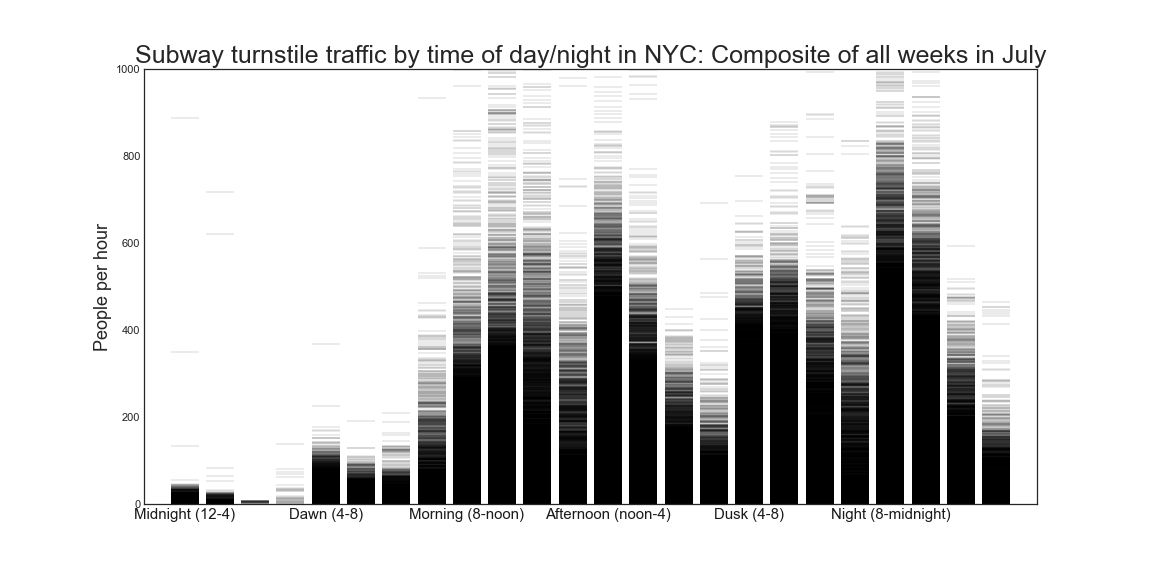

In [87]:
plt.figure(figsize=(16,8))

station_list = list([turnstile_station])

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = [0, 4, 8, 12, 16, 20]
time_name = dict({0:'Midnight (12-4)', 4:'Dawn (4-8)', 8: 'Morning (8-noon)', 12: 'Afternoon (noon-4)',16:'Dusk (4-8)',20:'Night (8-midnight)'})
times = [time_name[t] for t in ticks_x]
#times =[0, 4, 8, 12, 16, 20]
plt.xticks(ticks_x, times, fontsize = '15', color='k');


size_ = 800
alpha_ = .1
plt.ylim([0, 1000])

plt.title('Subway turnstile traffic by time of day/night in NYC: Composite of all weeks in July', fontsize='25')
plt.ylabel('People per hour', fontsize='18')

# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[0]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[0]]['People_per_hour'], marker='.', s=(size_,), alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[1]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[1]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[2]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[2]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[3]]['Day_hour'], y=turnstile_station[turnstile_station['STATION']==station_list[3]]['People_per_hour'], marker='.', s=(size_,),  alpha = alpha_)

plt.scatter( x=station_list[0]['Hour'], y=station_list[0]['People_per_hour'], marker='_', s=(size_,), color='black', alpha=alpha_)
# plt.scatter( x=station_list[2]['Day_hour'], y=station_list[2]['People_per_hour'], marker='_', s=(size_,), color='red', alpha=alpha_)
# plt.scatter( x=station_list[1]['Day_hour'], y=station_list[1]['People_per_hour'], marker='_', s=(size_,), color='blue', alpha=alpha_)
# plt.scatter( x=station_list[0]['Day_hour'], y=station_list[0]['People_per_hour'], marker='_', s=(size_,), color='green', alpha=alpha_)

#plt.savefig('Hourly_turnstile_fluctuation_in_NYC.png',transparent=True, bbox_inches='tight')
#plt.savefig('Hourly_turnstile_fluctuation_in_NYC.png',transparent=True, bbox_inches='tight')
plt.savefig('Hourly_turnstile_fluctuation_in_NYC.png',transparent=True, bbox_inches='tight')

In [88]:
stations_avg_by_time = turnstile_station.groupby(['Hour']).agg({'People_per_hour': ['mean']}).reset_index()

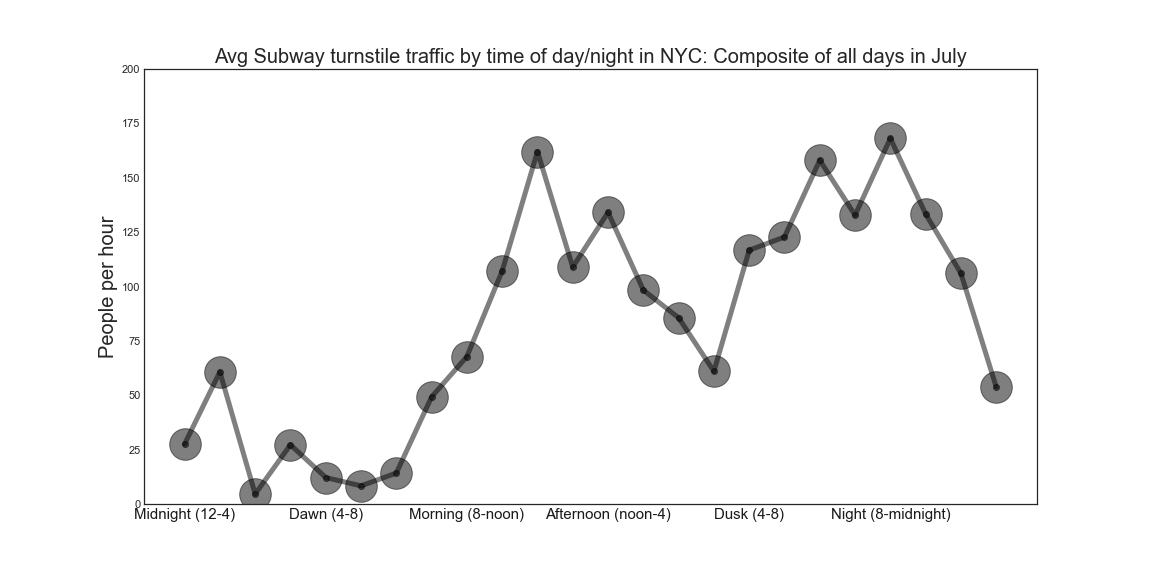

In [89]:

plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
station_list = list([stations_avg_by_time]) 
# ticks_x = np.linspace(0.5, 6.5, 6)
ticks_x = [0, 4, 8, 12, 16, 20]
time_name = dict({0:'Midnight (12-4)', 4:'Dawn (4-8)', 8: 'Morning (8-noon)', 12: 'Afternoon (noon-4)',16:'Dusk (4-8)',20:'Night (8-midnight)'})
times = [time_name[t] for t in ticks_x]
#times =[0, 4, 8, 12, 16, 20]
plt.xticks(ticks_x, times, fontsize = '15', color='k');
size_ = 1000
alpha_ = .5

plt.title('Avg Subway turnstile traffic by time of day/night in NYC: Composite of all days in July', fontsize='20')
plt.ylabel('People per hour', fontsize='20')
plt.ylim([0.0, 200.0])

#for i in range(len(station_list)):
station=0
plt.scatter( x=station_list[station]['Hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color='black', alpha=alpha_)
plt.plot( station_list[station]['Hour'], station_list[station]['People_per_hour'], marker='o', color='black', alpha=alpha_, lw='5')

# station=1
# plt.scatter( x=station_list[station]['Hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_)
# station=2
# plt.scatter( x=station_list[station]['Hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_)
# station=3
# plt.scatter( x=station_list[station]['Hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_)

# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[1]]['Hour'], y=turnstile_station[turnstile_station['STATION']==station_list[1]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[2]]['Hour'], y=turnstile_station[turnstile_station['STATION']==station_list[2]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[3]]['Hour'], y=turnstile_station[turnstile_station['STATION']==station_list[3]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)

plt.savefig('Avg_Hourly_turnstile_fluctuation_in_NYC.svg',transparent=True)

In [90]:
# station_list = list([turnstile_station])

# plt.figure(figsize=(16,6))

# colors_ = dict({0:'green', 1:'blue', 2: 'red', 3: 'orange'})

# # ticks_x = np.linspace(0.5, 6.5, 6)
# ticks_x = [0, 4, 8, 12, 16, 20]
# time_name = dict({0:'Midnight (12-4)', 4:'Dawn (4-8)', 8: 'Morning (8-noon)', 12: 'Afternoon (noon-4)',16:'Dusk (4-8)',20:'Night (8-midnight)'})
# times = [time_name[t] for t in ticks_x]
# #times =[0, 4, 8, 12, 16, 20]
# plt.xticks(ticks_x, times, fontsize = '15', color='k');
# size_ = 1000
# alpha_ = .1

# plt.title('Subway turnstile traffic in NYC: Composite of all weeks in July', fontsize='25')
# plt.ylabel('People per hour', fontsize='18')

# ticks_x = range(7)
# # days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
# plt.xticks(ticks_x, times, fontsize = '20', color='k');

# plt.scatter( x=turnstile_station['Day_num'], y=turnstile_station['People_per_hour'], marker='_', s=(300,), alpha=.2, color='black')


# plt.savefig('Daily_turnstile_fluctuation_in_NYC.svg',transparent=True, bbox_inches='tight')

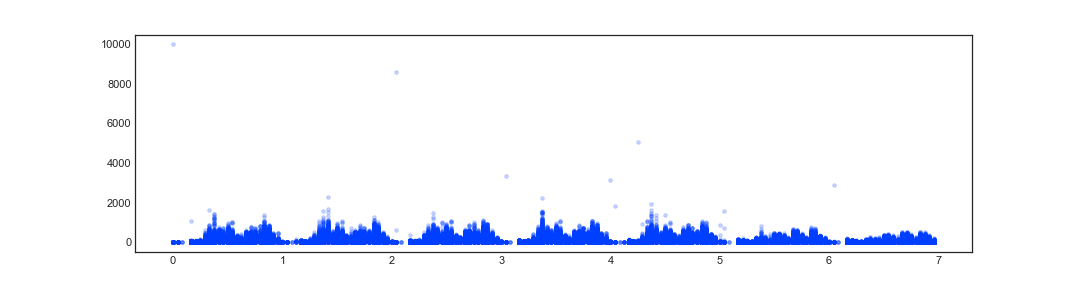

In [91]:
plt.figure(figsize=(15,4))

plt.scatter( x=turnstile_station['Day_hour'], y=turnstile_station['People_per_hour'], marker='.', s=(50,), alpha=.2)


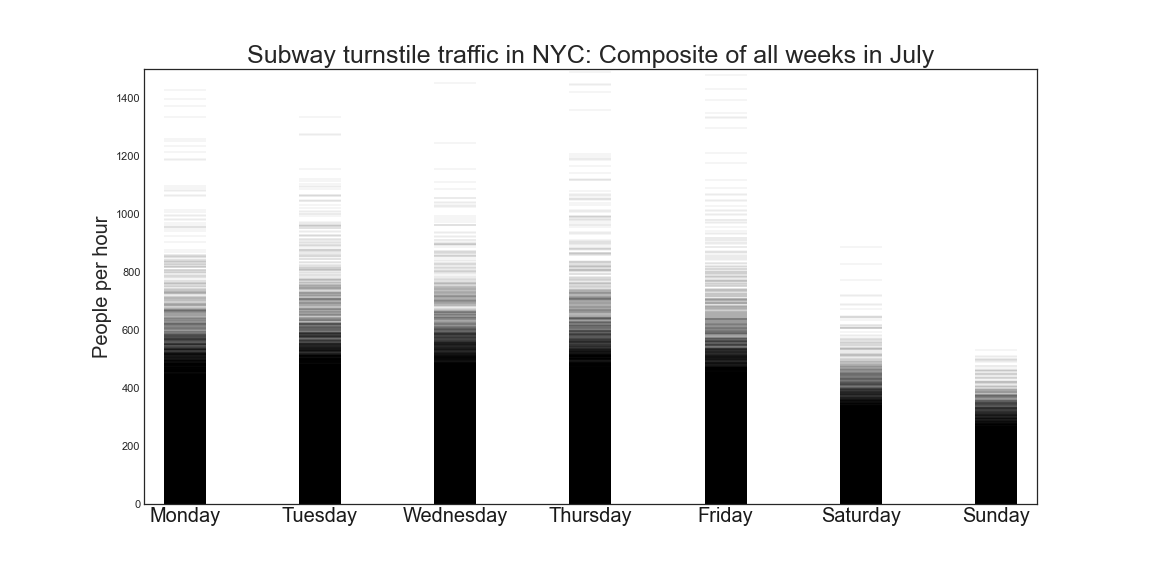

In [92]:
#station_list = turnstile_station['STATION'].unique().tolist()
plt.figure(figsize=(16,8))

station_list = list([turnstile_station])

ticks_x = range(7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 1800
alpha_ = .05

plt.ylim([0.0,1500.0])
plt.title('Subway turnstile traffic in NYC: Composite of all weeks in July', fontsize='25')
plt.ylabel('People per hour', fontsize='20')

neutral='black'
plt.scatter( x=station_list[0]['Day_num'], y=station_list[0]['People_per_hour'], marker='_', s=(size_,), color=neutral, alpha=alpha_)
# plt.scatter( x=station_list[1]['Day_num'], y=station_list[1]['People_per_hour'], marker='_', s=(size_,), color='blue', alpha=alpha_)
# plt.scatter( x=station_list[2]['Day_num'], y=station_list[2]['People_per_hour'], marker='_', s=(size_,), color='red', alpha=alpha_)
# plt.scatter( x=station_list[3]['Day_num'], y=station_list[3]['People_per_hour'], marker='_', s=(size_,), color='orange', alpha=alpha_)



# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[0]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[0]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[1]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[1]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[2]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[2]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[3]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[3]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
plt.savefig('Daily_turnstile_fluctuation_in_NYC.png',transparent=True)

In [93]:
stations_avg_by_day = turnstile_station.groupby(['Day_num']).agg({'People_per_hour': ['mean']}).reset_index()

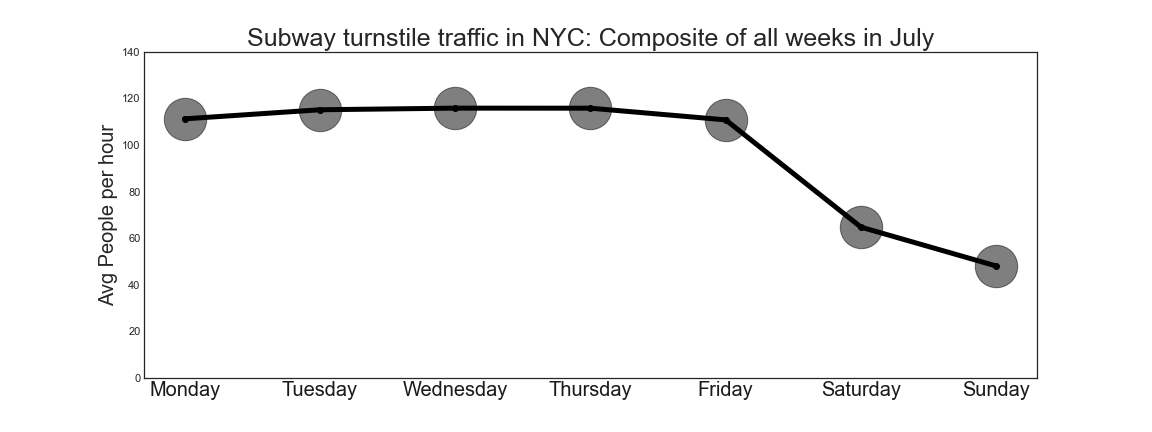

<Figure size 2880x720 with 0 Axes>

In [94]:
plt.figure(figsize=(16,6))


plt.title('Subway turnstile traffic in NYC: Composite of all weeks in July', fontsize='25')
plt.ylabel('Avg People per hour', fontsize='20')
plt.ylim([0.0, 140.0])

ticks_x = range(7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');

alpha_=.5
#plt.scatter( x=stations_avg_hourly['Day_num'], y=stations_avg_hourly ['People_per_hour'], marker='o', s=(300,), alpha=1, color='black')

plt.scatter( x=stations_avg_by_day['Day_num'], y=stations_avg_by_day['People_per_hour'], marker='o', s=(size_,), color='black', alpha=alpha_)
plt.plot( stations_avg_by_day['Day_num'], stations_avg_by_day['People_per_hour'], marker='o', alpha=1, color='black', lw=5);
plt.show()

plt.savefig('Avg_Daily_turnstile_fluctuation_in_NYC.svg',transparent=True)

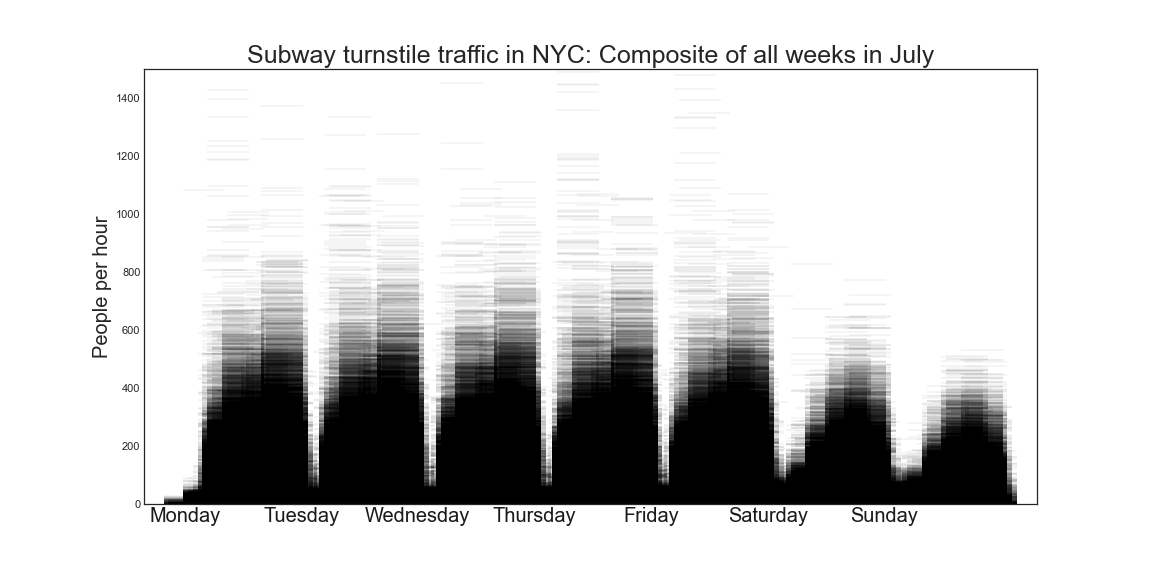

In [95]:
#station_list = turnstile_station['STATION'].unique().tolist()
plt.figure(figsize=(16,8))

station_list = list([turnstile_station])

ticks_x = range(7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 1800
alpha_ = .05


plt.title('Subway turnstile traffic in NYC: Composite of all weeks in July', fontsize='25')
plt.ylabel('People per hour', fontsize='20')

neutral='black'
plt.scatter( x=station_list[0]['Day_hour'], y=station_list[0]['People_per_hour'], marker='_', s=(size_,), color=neutral, alpha=alpha_)
# plt.scatter( x=station_list[1]['Day_num'], y=station_list[1]['People_per_hour'], marker='_', s=(size_,), color='blue', alpha=alpha_)
# plt.scatter( x=station_list[2]['Day_num'], y=station_list[2]['People_per_hour'], marker='_', s=(size_,), color='red', alpha=alpha_)
# plt.scatter( x=station_list[3]['Day_num'], y=station_list[3]['People_per_hour'], marker='_', s=(size_,), color='orange', alpha=alpha_)
plt.ylim([0.0, 1500.0])


# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[0]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[0]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[1]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[1]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[2]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[2]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
# plt.scatter( x=turnstile_station[turnstile_station['STATION']==station_list[3]]['Day_num'], y=turnstile_station[turnstile_station['STATION']==station_list[3]]['People_per_hour'], marker='.', s=(size_,), alpha=alpha_)
plt.savefig('Daily_turnstile_fluctuation_in_NYC.png',transparent=True)

In [96]:
stations_list = [turnstile_station]
stations_list[0].shape

(592496, 11)

In [97]:
#stations_list_avg_hourly.shape

In [98]:
# plt.figure(figsize=(16,8))
# # stations_avg_by_day = turnstile_station.groupby(['Day_num']).agg({'People_per_hour': ['mean']}).reset_index()
# stations_list = list([stations_avg_hourly]) 

# #station_list = turnstile_station['STATION'].unique().tolist()
# # station_list = flatiron_stations

# colors_ = dict({0:'green', 1:'blue', 2: 'red', 3: 'orange', 4: 'black'})

# # ticks_x = np.linspace(0.5, 6.5, 6)
# ticks_x = [0, 4, 8, 12, 16, 20]
# time_name = dict({0:'Midnight (12-4)', 4:'Dawn (4-8)', 8: 'Morning (8-noon)', 12: 'Afternoon (noon-4)',16:'Dusk (4-8)',20:'Night (8-midnight)'})
# times = [time_name[t] for t in ticks_x]
# #times =[0, 4, 8, 12, 16, 20]
# plt.xticks(ticks_x, times, fontsize = '15', color='k');
# size_ = 100
# alpha_ = 1
# plt.ylim([0, 280])

# plt.title('Subway turnstile traffic by time of day/night in NYC: Composite of all days in July', fontsize='20')
# plt.ylabel('People per hour', fontsize='20')

# #for i in range(len(station_list)):
# plt.scatter( x=station_list[0]['Hour'], y=station_list[0]['People_per_hour'], marker='o', s=(size_,), color=colors_[4], alpha=alpha_)

# plt.savefig('Hourly_turnstile_fluctuation_in_NYC.svg',transparent=True, bbox_inches='tight')

In [99]:
# stations_avg_hourly = turnstile_station.groupby(['Hour']).mean().reset_index()


stations_avg_hourly = turnstile_station.groupby(['Hour']).agg({'People_per_hour': ['mean']}).reset_index()
stations_avg_hourly.head(50)



,Hour,People_per_hour
,,mean
0,0,27.545431
1,1,60.743311
2,2,4.596296
3,3,27.236559
4,4,12.173039
5,5,8.346044
6,6,14.213769
7,7,49.254431
8,8,67.808400


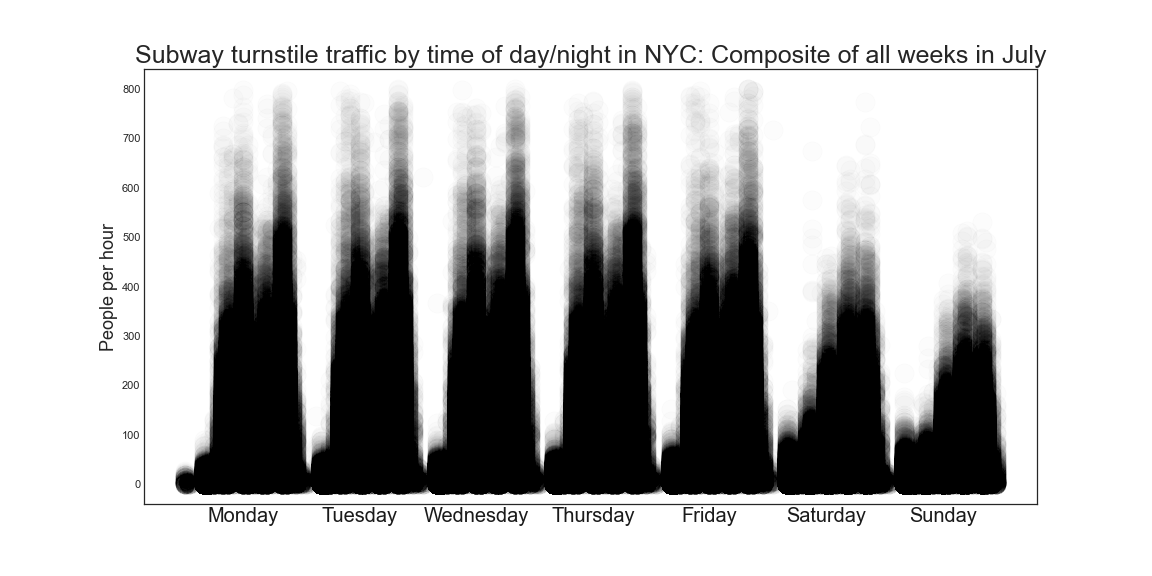

In [100]:
plt.figure(figsize=(16,8))

station_list = list([turnstile_station[turnstile_station["People_per_hour"]<800]])

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 370
alpha_ = .01

plt.title('Subway turnstile traffic by time of day/night in NYC: Composite of all weeks in July', fontsize='25')
plt.ylabel('People per hour', fontsize='18')

plt.scatter( x=station_list[0]['Day_hour'], y=station_list[0]['People_per_hour'], marker='o', s=(size_,), color='black', alpha=alpha_)

plt.savefig('Day_hourly_turnstile_fluctuation_in_NYC.png',transparent=True, bbox_inches='tight')
plt.show()

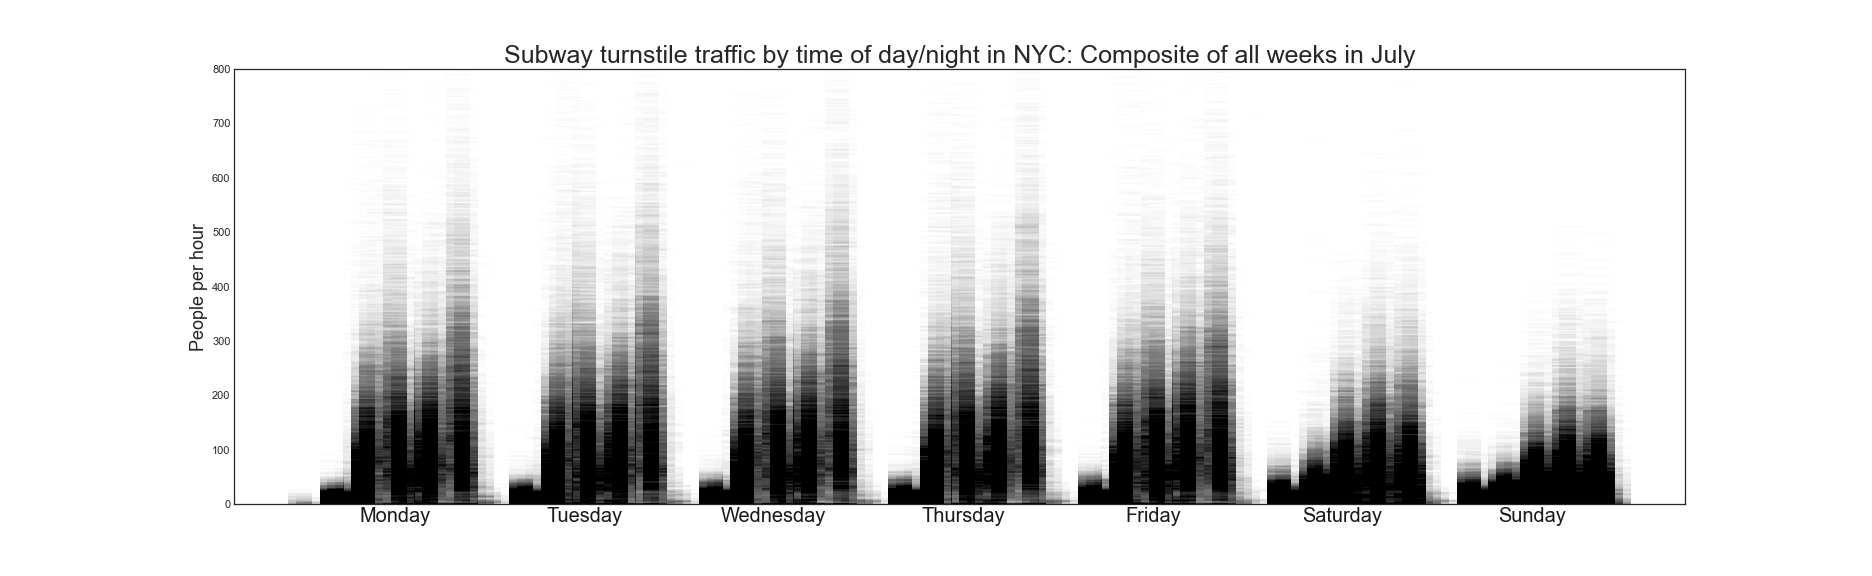

In [101]:
plt.figure(figsize=(26,8))

station_list = list([turnstile_station])

ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 600
alpha_ = .01

plt.title('Subway turnstile traffic by time of day/night in NYC: Composite of all weeks in July', fontsize='25')
plt.ylabel('People per hour', fontsize='18')


plt.scatter( x=turnstile_station['Day_hour'], y=turnstile_station['People_per_hour'], marker='_', s=(size_,), color='black', alpha=alpha_)

plt.ylim([0.0, 800.0])

plt.savefig('Day_hourly_turnstile_fluctuation_in_NYC.png',transparent=True, bbox_inches='tight')
plt.show()

In [102]:
stations_avg_by_day_hour = turnstile_station.groupby(['Day_hour']).agg({'People_per_hour': ['mean']}).reset_index()

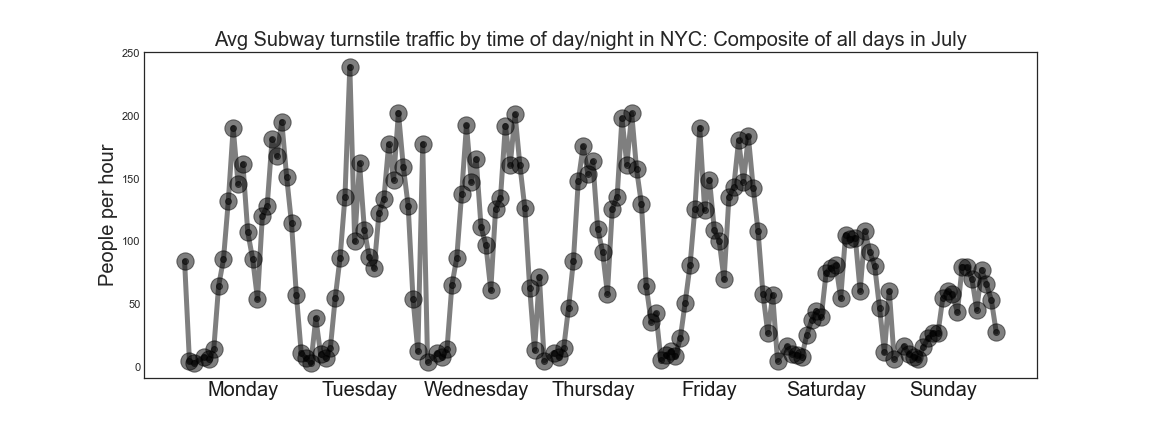

In [103]:
plt.figure(figsize=(16,6))

#station_list = turnstile_station['STATION'].unique().tolist()
station_list = list([stations_avg_by_day_hour])
# ticks_x = np.linspace(0.5, 6.5, 6)
# ticks_x = [0, 4, 8, 12, 16, 20]
# time_name = dict({0:'Midnight (12-4)', 4:'Dawn (4-8)', 8: 'Morning (8-noon)', 12: 'Afternoon (noon-4)',16:'Dusk (4-8)',20:'Night (8-midnight)'})
# times = [time_name[t] for t in ticks_x]
# #times =[0, 4, 8, 12, 16, 20]

ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');

size_ = 300
alpha_ = .5

plt.title('Avg Subway turnstile traffic by time of day/night in NYC: Composite of all days in July', fontsize='20')
plt.ylabel('People per hour', fontsize='20')

neutral='black'

#for i in range(len(station_list)):
station=0
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=neutral, alpha=alpha_)
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o',  color=neutral, alpha=alpha_, lw='5')


plt.savefig('Avg_Day_Hourly_turnstile_fluctuation_in_NYC.svg',transparent=True, bbox_inches='tight')

In [106]:
twenty_third_st_stations = turnstile_station[turnstile_station['STATION'].str.contains('23 ST')]
flatiron = twenty_third_st_stations[twenty_third_st_stations['LINENAME'].str.contains('N')]
gramercy = twenty_third_st_stations [twenty_third_st_stations ['LINENAME'].str.contains('6')]
sixth_ave_23 = twenty_third_st_stations[twenty_third_st_stations ['LINENAME'].str.contains('F')]
union_sq = turnstile_station[turnstile_station['STATION'].str.contains('14 ST-UNION SQ')]

flatiron_stations = [flatiron, gramercy, sixth_ave_23, union_sq]

flatiron_stations_avg_pp_day_hour = [station.groupby(['Day_hour']).agg({'People_per_hour': ['mean']}).reset_index() for station in flatiron_stations]
flatiron_stations_avg_pp_hour = [station.groupby(['Hour']).agg({'People_per_hour': ['mean']}).reset_index() for station in flatiron_stations]
flatiron_stations_avg_pp_day = [station.groupby(['Day_num']).agg({'People_per_hour': ['mean']}).reset_index() for station in flatiron_stations]

# flatiron_stations_avg = agg({'People_per_hour': ['mean']})

In [107]:
flatiron_stations_avg_pp_day_hour[0].head() 
#twenty_third_st_stations.sample(20)

,Day_hour,People_per_hour
,,mean
0,0.166667,3.258929
1,0.333333,32.339286
2,0.500000,169.808036
3,0.666667,132.758929
4,0.833333,259.433036


In [108]:
twenty_third_st_stations.sample(5) 

,STATION,LINENAME,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income
620952,23 ST,6,2019-05-16 09:00:00,Thursday,3,9,3.375000,133.75,40.739864,-73.986599,104238.0
620068,23 ST,6,2019-05-11 13:00:00,Saturday,5,13,5.541667,62.75,40.739864,-73.986599,104238.0
396245,23 ST,FM,2019-05-19 16:00:00,Sunday,6,16,6.666667,95.00,40.742878,-73.992821,104238.0
222464,23 ST,CE,2019-05-21 12:00:00,Tuesday,1,12,1.500000,145.25,40.745906,-73.998041,104238.0
221345,23 ST,CE,2019-04-30 08:00:00,Tuesday,1,8,1.333333,54.50,40.745906,-73.998041,104238.0


In [109]:
flatiron.head()


,STATION,LINENAME,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income
15590,23 ST,NRW,2019-04-27 04:00:00,Saturday,5,4,5.166667,1.50,40.741303,-73.989344,104238.0
15591,23 ST,NRW,2019-04-27 08:00:00,Saturday,5,8,5.333333,13.25,40.741303,-73.989344,104238.0
15592,23 ST,NRW,2019-04-27 12:00:00,Saturday,5,12,5.500000,39.25,40.741303,-73.989344,104238.0
15593,23 ST,NRW,2019-04-27 16:00:00,Saturday,5,16,5.666667,69.00,40.741303,-73.989344,104238.0
15594,23 ST,NRW,2019-04-27 20:00:00,Saturday,5,20,5.833333,50.75,40.741303,-73.989344,104238.0


In [110]:

gramercy.head()

,STATION,LINENAME,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income
618123,23 ST,6,2019-04-27 05:00:00,Saturday,5,5,5.208333,8.25,40.739864,-73.986599,104238.0
618124,23 ST,6,2019-04-27 09:00:00,Saturday,5,9,5.375000,51.75,40.739864,-73.986599,104238.0
618125,23 ST,6,2019-04-27 13:00:00,Saturday,5,13,5.541667,108.00,40.739864,-73.986599,104238.0
618126,23 ST,6,2019-04-27 17:00:00,Saturday,5,17,5.708333,134.50,40.739864,-73.986599,104238.0
618127,23 ST,6,2019-04-27 21:00:00,Saturday,5,21,5.875000,93.00,40.739864,-73.986599,104238.0


In [111]:
union_sq.head()

,STATION,LINENAME,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income
17950,14 ST-UNION SQ,LNQR456W,2019-04-27 01:00:00,Saturday,5,1,5.041667,6.00,40.735066,-73.990416,92540.0
17951,14 ST-UNION SQ,LNQR456W,2019-04-27 05:00:00,Saturday,5,5,5.208333,3.25,40.735066,-73.990416,92540.0
17952,14 ST-UNION SQ,LNQR456W,2019-04-27 09:00:00,Saturday,5,9,5.375000,31.50,40.735066,-73.990416,92540.0
17953,14 ST-UNION SQ,LNQR456W,2019-04-27 13:00:00,Saturday,5,13,5.541667,140.75,40.735066,-73.990416,92540.0
17954,14 ST-UNION SQ,LNQR456W,2019-04-27 17:00:00,Saturday,5,17,5.708333,217.25,40.735066,-73.990416,92540.0


In [287]:
labels  = ['Flatiron', 'Gramercy','Sixth Ave. Chelsea', 'Union Sq']

### Notes about the color graphics that follow:
1. These could be developed quickly because one of my teammates assisted at the right time: **Chuck Cao** supplied the initial conversion of the the single-color graphs to the multicolored graphs seen below. 
2. For the scatter plots, the nature of the data prompted me to experiment with which scattorplot symbol best visualizes the distribution of points. 

**The advantage of this style of scatterplot, using this horizontal strips:**
Specifically, I used time-series scatterplots of traffic at every turnstile, with the graph adjusted to use thin horizontal colored strips rather than tiny colored points. (The strips have more visual presence without occluding each other as much as comparably sized dots); 2. time-series scatterplots of the aggregated mean (average) amount of turnstile traffic during each four-hour period. From these visualizations, I noticed an intriguing pattern: Unlike the peak turnstile traffic during morning and afternoon/evening rush hours at the busiest subway stations, turnstile traffic at NYC stations overall instead peaks in the late-evening hours between 8pm and midnight (often with a lesser peak in the early afternoon). This pattern holds true for the specific stations we analyzed as well.

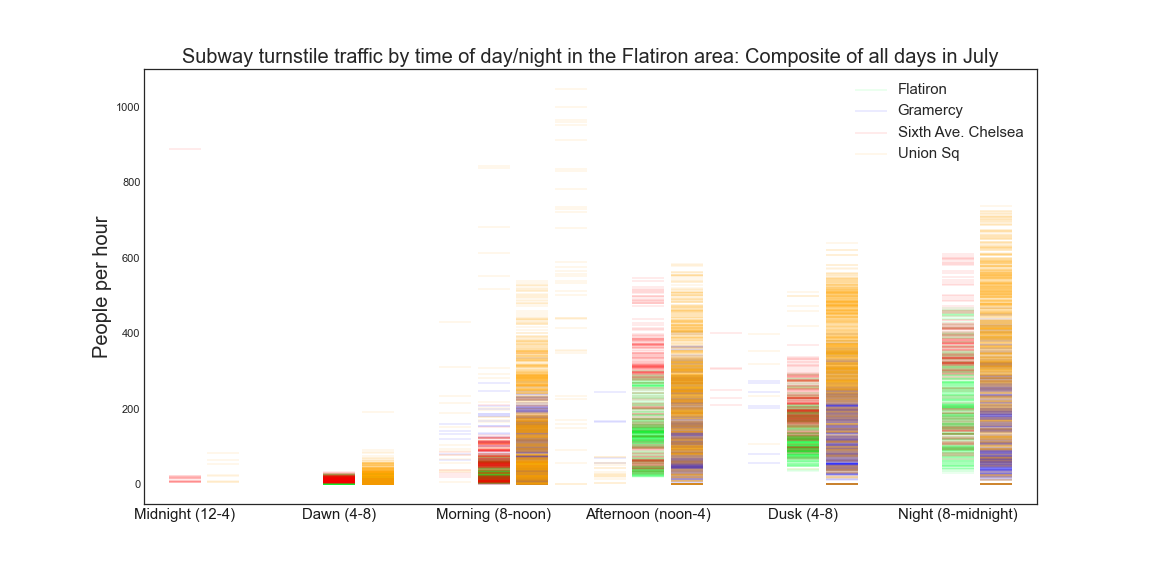

In [113]:
import numpy as np
plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
station_list = flatiron_stations

bright_green = '#00ff33'
colors_ = dict({0:bright_green, 1:'blue', 2: 'red', 3: 'orange'})

# ticks_x = np.linspace(0.5, 6.5, 6)
ticks_x = [0, 4, 8, 12, 16, 20]
time_name = dict({0:'Midnight (12-4)', 4:'Dawn (4-8)', 8: 'Morning (8-noon)', 12: 'Afternoon (noon-4)',16:'Dusk (4-8)',20:'Night (8-midnight)'})
times = [time_name[t] for t in ticks_x]
#times =[0, 4, 8, 12, 16, 20]
plt.xticks(ticks_x, times, fontsize = '15', color='k');
size_ = 1000
alpha_ = .1

plt.title('Subway turnstile traffic by time of day/night in the Flatiron area: Composite of all days in July', fontsize='20')
plt.ylabel('People per hour', fontsize='20')

#for i in range(len(station_list)):
plt.scatter( x=station_list[0]['Hour'], y=station_list[0]['People_per_hour'], marker='_', s=(size_,), color=colors_[0], alpha=alpha_, label=labels[0])
plt.scatter( x=station_list[1]['Hour'], y=station_list[1]['People_per_hour'], marker='_', s=(size_,), color=colors_[1], alpha=alpha_, label=labels[1])
plt.scatter( x=station_list[2]['Hour'], y=station_list[2]['People_per_hour'], marker='_', s=(size_,), color=colors_[2], alpha=alpha_, label=labels[2])
plt.scatter( x=station_list[3]['Hour'], y=station_list[3]['People_per_hour'], marker='_', s=(size_,), color=colors_[3], alpha=alpha_, label=labels[3])


plt.legend(fontsize='15')
plt.savefig('Hourly_turnstile_fluctuation_at_4_stations.svg',transparent=True, bbox_inches='tight')

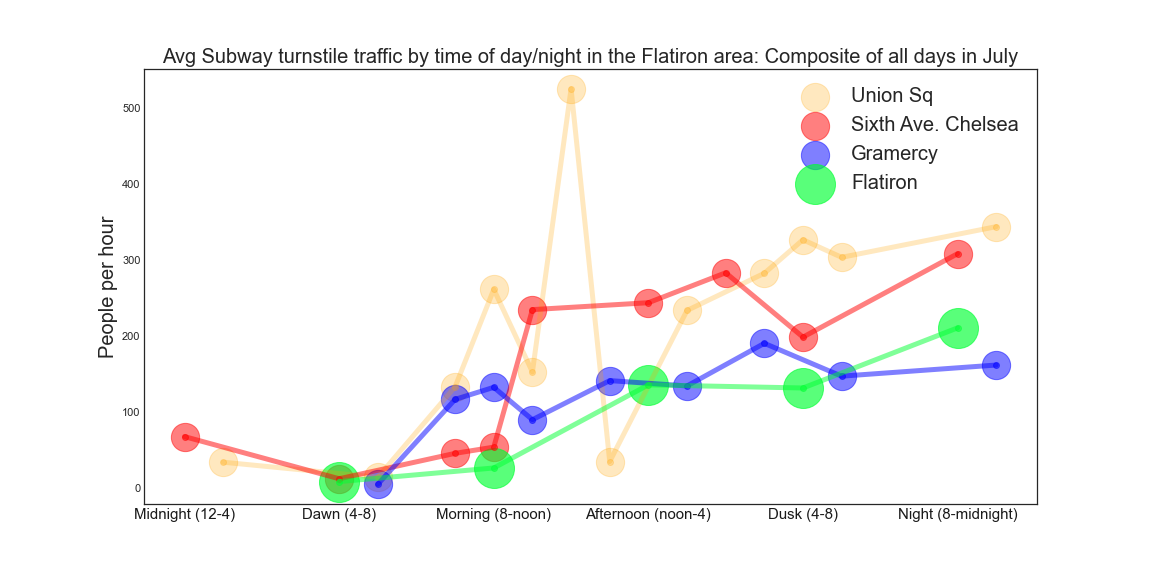

<Figure size 2880x720 with 0 Axes>

In [114]:
import numpy as np
plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
station_list = flatiron_stations_avg_pp_hour
# ticks_x = np.linspace(0.5, 6.5, 6)
ticks_x = [0, 4, 8, 12, 16, 20]
time_name = dict({0:'Midnight (12-4)', 4:'Dawn (4-8)', 8: 'Morning (8-noon)', 12: 'Afternoon (noon-4)',16:'Dusk (4-8)',20:'Night (8-midnight)'})
times = [time_name[t] for t in ticks_x]
#times =[0, 4, 8, 12, 16, 20]
plt.xticks(ticks_x, times, fontsize = '15', color='k');
size_ = 800
alpha_ = .5

colors_ = dict({0:bright_green, 1:'blue', 2: 'red', 3: 'orange'})

plt.title('Avg Subway turnstile traffic by time of day/night in the Flatiron area: Composite of all days in July', fontsize='20')
plt.ylabel('People per hour', fontsize='20')

#for i in range(len(station_list)):
alpha_*=.5
station=3
plt.scatter( x=station_list[station]['Hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Hour'], station_list[station]['People_per_hour'], marker='o',  color=colors_[station], alpha=alpha_, lw='5')

alpha_ = .5
station=2
plt.scatter( x=station_list[station]['Hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Hour'], station_list[station]['People_per_hour'], marker='o',  color=colors_[station], alpha=alpha_, lw='5')

station=1
plt.scatter( x=station_list[station]['Hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Hour'], station_list[station]['People_per_hour'], marker='o',  color=colors_[station], alpha=alpha_, lw='5')


station=0
plt.scatter( x=station_list[station]['Hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_*2,), color=colors_[station], alpha=alpha_*1.3, label=labels[station])
plt.plot( station_list[station]['Hour'], station_list[station]['People_per_hour'], marker='o',  color=colors_[station], alpha=alpha_, lw='5')

plt.legend(fontsize='20')
plt.show()
plt.savefig('Avg_Hourly_turnstile_fluctuation_at_4_stations.svg',transparent=True)

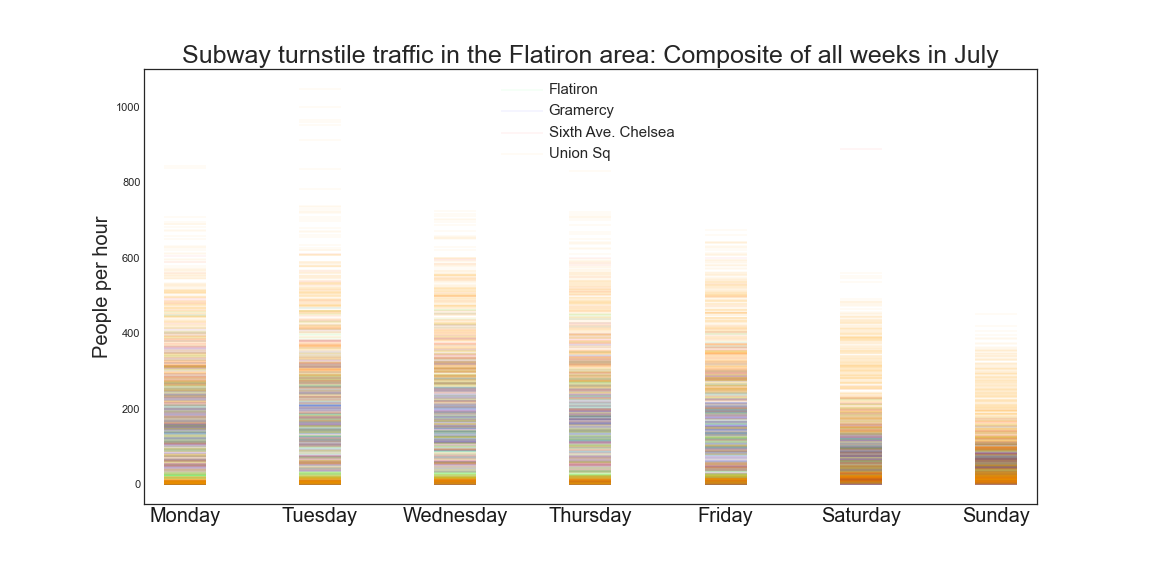

<Figure size 2880x720 with 0 Axes>

In [115]:
#station_list = turnstile_station['STATION'].unique().tolist()
colors_ = dict({0:bright_green, 1:'blue', 2: 'red', 3: 'orange'})

plt.figure(figsize=(16,8))

station_list = flatiron_stations

ticks_x = range(7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 1800
alpha_ = .05

plt.title('Subway turnstile traffic in the Flatiron area: Composite of all weeks in July', fontsize='25')
plt.ylabel('People per hour', fontsize='20')

station=0
plt.scatter( x=station_list[station]['Day_num'], y=station_list[station]['People_per_hour'], marker='_', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
station=1
plt.scatter( x=station_list[station]['Day_num'], y=station_list[station]['People_per_hour'], marker='_', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
station=2
plt.scatter( x=station_list[station]['Day_num'], y=station_list[station]['People_per_hour'], marker='_', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
station=3
plt.scatter( x=station_list[station]['Day_num'], y=station_list[station]['People_per_hour'], marker='_', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])

plt.legend(fontsize='15')
plt.show()


plt.savefig('Daily_turnstile_fluctuation_at_4_stations.svg',transparent=True, bbox_inches='tight')

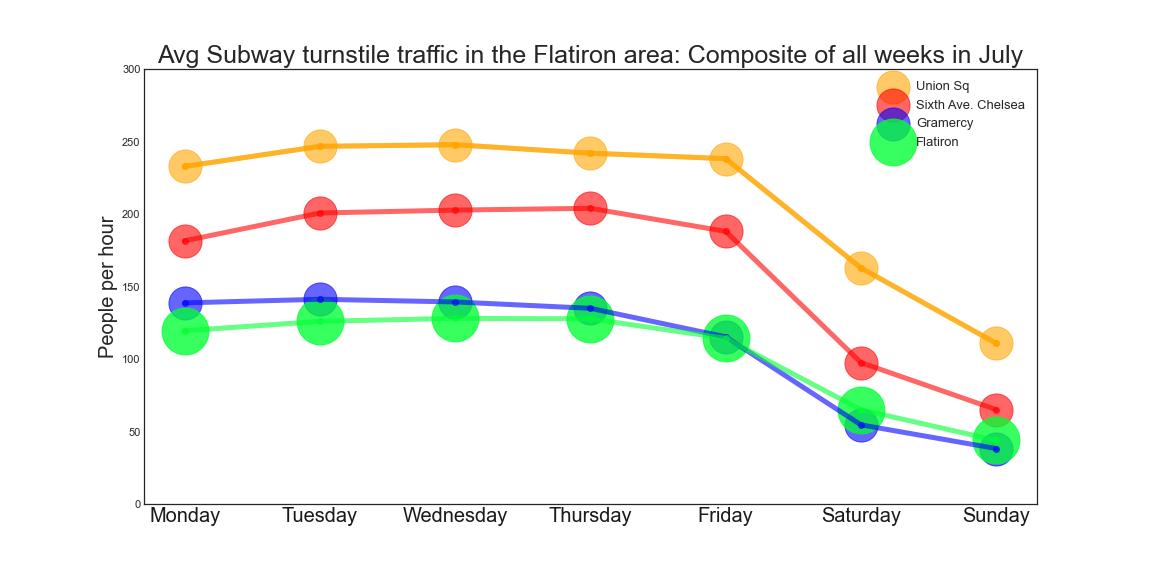

In [116]:
plt.figure(figsize=(16,8))

station_list  = flatiron_stations_avg_pp_day

colors_ = dict({0:bright_green, 1:'blue', 2: 'red', 3: 'orange'})

ticks_x = range(7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 1100
alpha_ = .6

plt.title('Avg Subway turnstile traffic in the Flatiron area: Composite of all weeks in July', fontsize='25')
plt.ylabel('People per hour', fontsize='20')
plt.plot( station_list[station]['Day_num'], station_list[station]['People_per_hour'], marker='o', color=colors_[station], alpha=alpha_, lw='5')
plt.ylim([0.0, 300.0])

station=3
plt.scatter( x=station_list[station]['Day_num'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Day_num'], station_list[station]['People_per_hour'], marker='o', color=colors_[station], alpha=alpha_, lw='5')

station=2
plt.scatter( x=station_list[station]['Day_num'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Day_num'], station_list[station]['People_per_hour'], marker='o', color=colors_[station], alpha=alpha_, lw='5')

station=1
plt.scatter( x=station_list[station]['Day_num'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Day_num'], station_list[station]['People_per_hour'], marker='o', color=colors_[station], alpha=alpha_, lw='5')

station=0
plt.scatter( x=station_list[station]['Day_num'], y=station_list[station]['People_per_hour'], marker='o', s=(size_*2,), color=colors_[station], alpha=alpha_*1.3, label=labels[station])
plt.plot( station_list[station]['Day_num'], station_list[station]['People_per_hour'], marker='o', color=colors_[station], alpha=alpha_, lw='5')


plt.legend(fontsize='13')
plt.savefig('Avg_Daily_turnstile_fluctuation_at_4_stations.svg',transparent=True)

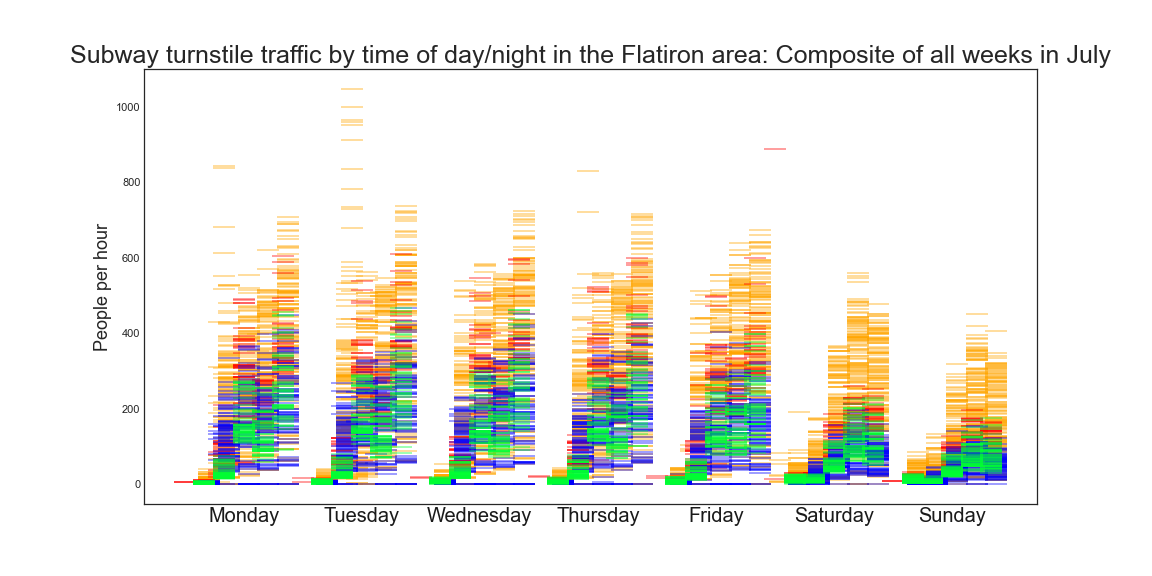

In [117]:
plt.figure(figsize=(16,8))

station_list = flatiron_stations

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5

plt.title('Subway turnstile traffic by time of day/night in the Flatiron area: Composite of all weeks in July', fontsize='25')
plt.ylabel('People per hour', fontsize='18')
#plt.ylim(0, 1000)

plt.scatter( x=station_list[3]['Day_hour'], y=station_list[3]['People_per_hour'], marker='_', s=(size_,), color='orange', alpha=alpha_)
plt.scatter( x=station_list[2]['Day_hour'], y=station_list[2]['People_per_hour'], marker='_', s=(size_,), color='red', alpha=alpha_)
plt.scatter( x=station_list[1]['Day_hour'], y=station_list[1]['People_per_hour'], marker='_', s=(size_,), color='blue', alpha=alpha_)
plt.scatter( x=station_list[0]['Day_hour'], y=station_list[0]['People_per_hour'], marker='_', s=(size_,), color='#00ff33', alpha=alpha_)


plt.savefig('Day_hourly_turnstile_fluctuation_at_4_stations.svg',transparent=True);


In [118]:
station_list = flatiron_stations_avg_pp_day_hour

In [119]:
station_list = flatiron_stations_avg_pp_day_hour

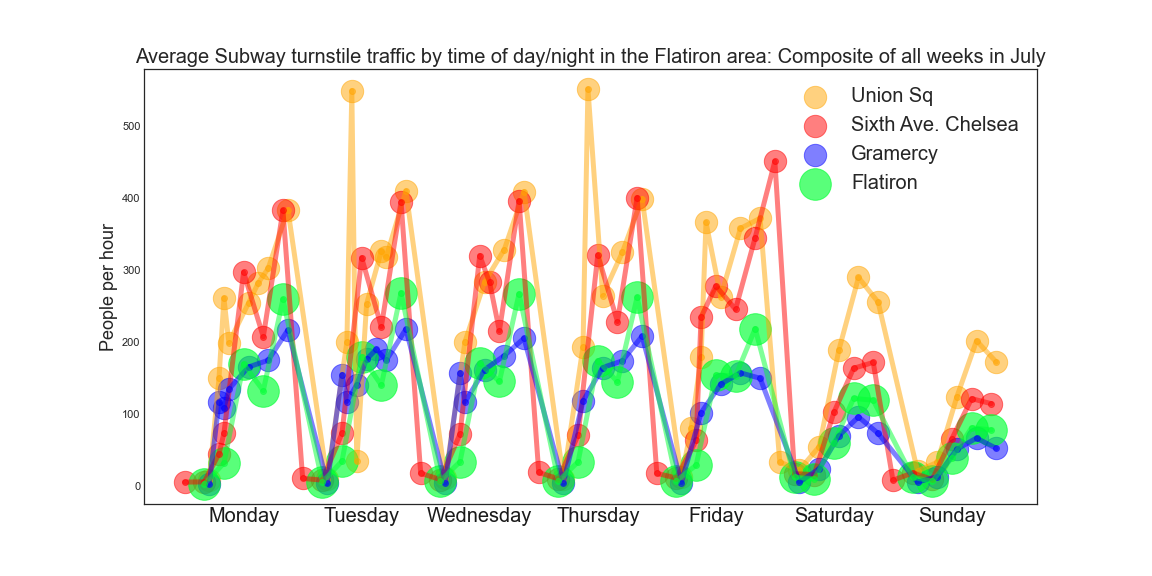

In [120]:
import numpy as np

station_list = flatiron_stations_avg_pp_day_hour

plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5
#plt.ylim(0, 750)

plt.title('Average Subway turnstile traffic by time of day/night in the Flatiron area: Composite of all weeks in July', fontsize='20')
plt.ylabel('People per hour', fontsize='18')


station=3
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o', color=colors_[station], alpha=alpha_, lw='5')

station=2
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o', color=colors_[station], alpha=alpha_, lw='5')

station=1
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o', color=colors_[station], alpha=alpha_, lw='5')

station=0
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_*2,), color=colors_[station], alpha=alpha_*1.3, label=labels[station])
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o', color=colors_[station], alpha=alpha_, lw='5')

plt.legend(fontsize=20)

plt.savefig('Avg_Day_hourly_turnstile_fluctuation_at_4_stations.svg',transparent=True)
plt.show()

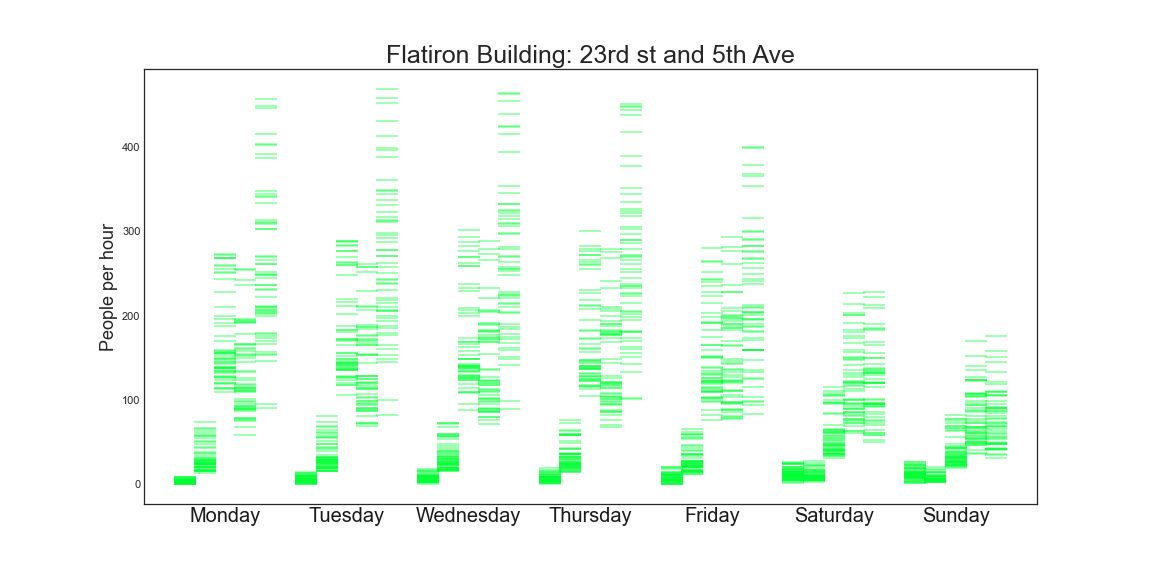

In [121]:
station_list = flatiron_stations

plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5

#plt.ylim([0, 1000])
plt.title('Flatiron Building: 23rd st and 5th Ave', fontsize='25')

plt.ylabel('People per hour', fontsize='18')

plt.scatter( x=station_list[0]['Day_hour'], y=station_list[0]['People_per_hour'], marker='_', s=(size_,), color=bright_green, alpha=alpha_)


plt.savefig('Day_hourly_turnstile_fluctuation_at_flatiron_station.svg',transparent=True)

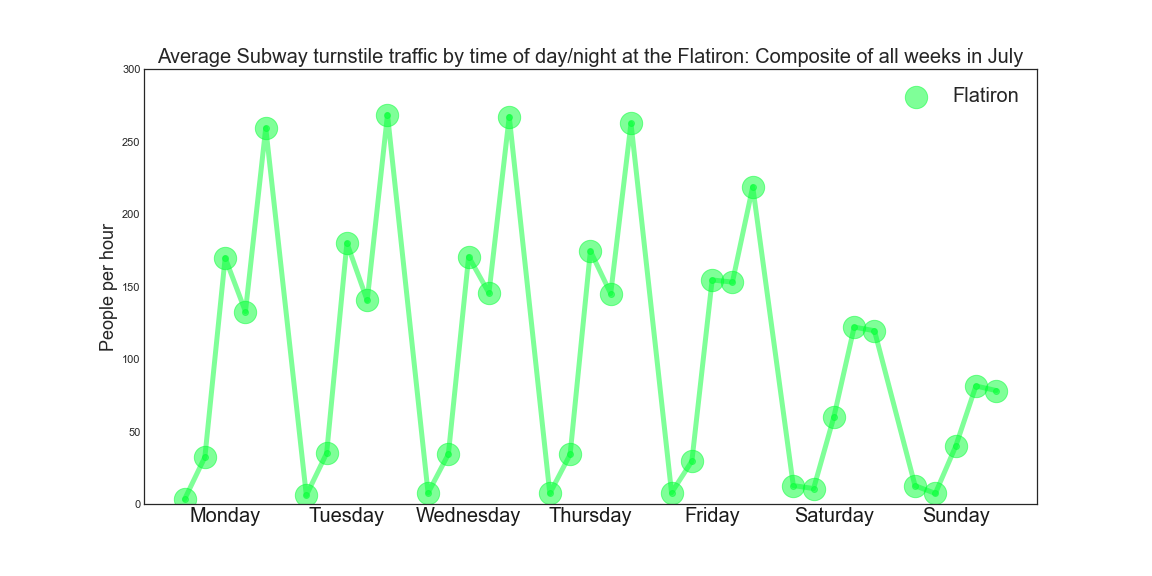

In [122]:
station_list = flatiron_stations_avg_pp_day_hour

plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5
plt.ylim([0.0, 300.0])

plt.title('Average Subway turnstile traffic by time of day/night at the Flatiron: Composite of all weeks in July', fontsize='20')
plt.ylabel('People per hour', fontsize='18')

station=0
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=colors_[station], alpha=alpha_, label=labels[0] )
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o', color=colors_[station], alpha=alpha_, lw='5')

station_list = flatiron_stations
plt.legend(fontsize=20)

plt.savefig('Avg_Day_hourly_turnstile_fluctuation_at_flatiron_station.svg',transparent=True)

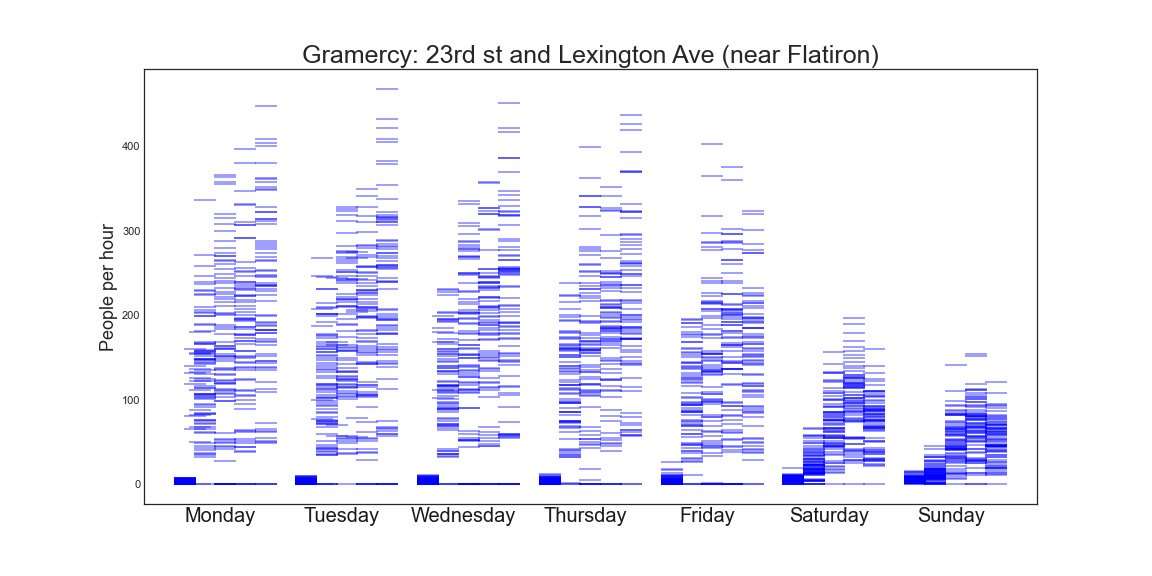

In [123]:
station_list = flatiron_stations


plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5

#plt.ylim([0, 1000])
plt.title('Gramercy: 23rd st and Lexington Ave (near Flatiron)', fontsize='25')

plt.ylabel('People per hour', fontsize='18')

plt.scatter( x=station_list[1]['Day_hour'], y=station_list[1]['People_per_hour'], marker='_', s=(size_,), color='blue', alpha=alpha_);


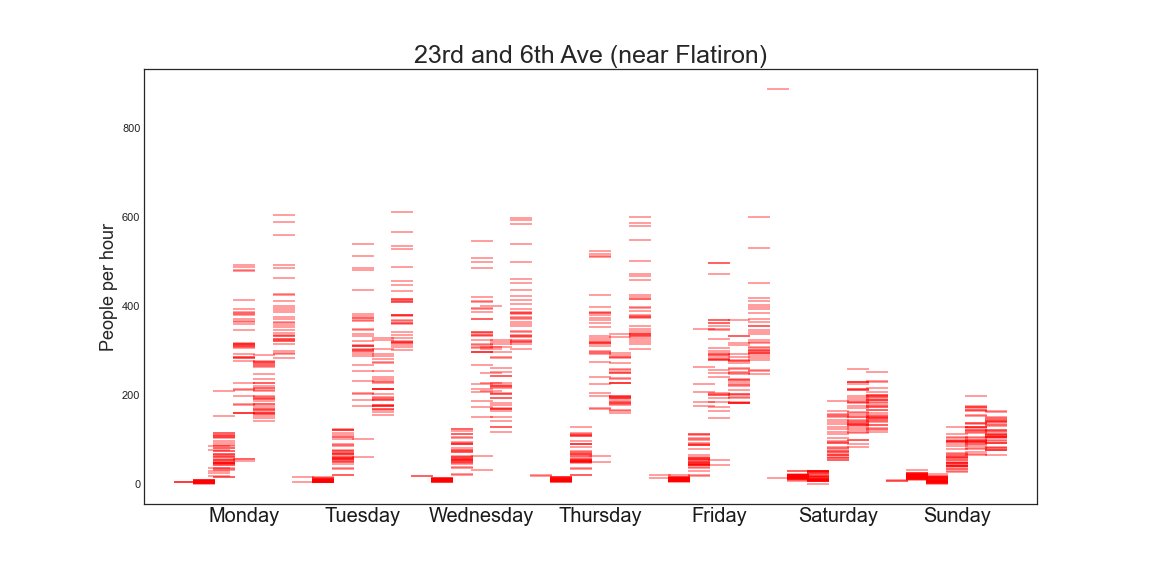

In [124]:
plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5

#plt.ylim([0, 1000])
plt.title('23rd and 6th Ave (near Flatiron)', fontsize='25')

plt.ylabel('People per hour', fontsize='18')

plt.scatter( x=station_list[2]['Day_hour'], y=station_list[2]['People_per_hour'], marker='_', s=(size_,), color='red', alpha=alpha_)
plt.savefig('Avg_Day_hourly_turnstile_fluctuation_at_Gramercy_station.svg',transparent=True)

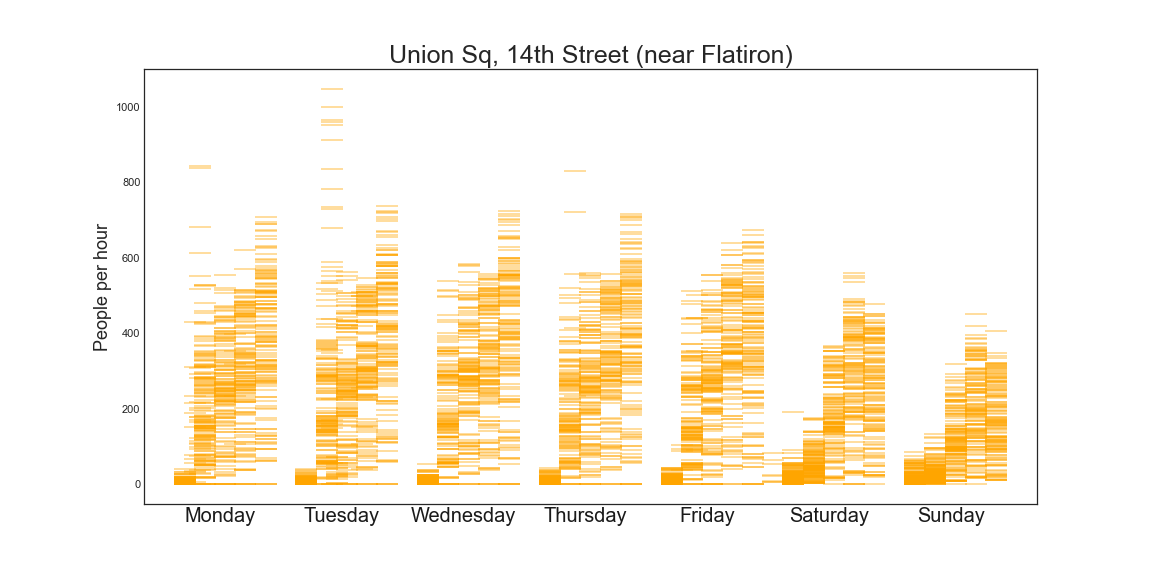

In [125]:
plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5

#plt.ylim([0, 1000])
plt.title('Union Sq, 14th Street (near Flatiron)', fontsize='25')

plt.ylabel('People per hour', fontsize='18')

plt.scatter( x=station_list[3]['Day_hour'], y=station_list[3]['People_per_hour'], marker='_', s=(size_,), color='orange', alpha=alpha_)


In [126]:
Flatiron_avg = station_list[0].groupby(['Day_hour']).mean().reset_index()
Flatiron_avg.head()

,Day_hour,Day_num,Hour,People_per_hour,GTFS Latitude,GTFS Longitude,income
0,0.166667,0,4,3.258929,40.741303,-73.989344,104238.0
1,0.333333,0,8,32.339286,40.741303,-73.989344,104238.0
2,0.500000,0,12,169.808036,40.741303,-73.989344,104238.0
3,0.666667,0,16,132.758929,40.741303,-73.989344,104238.0
4,0.833333,0,20,259.433036,40.741303,-73.989344,104238.0


### Flatiron train station in particular is shown below

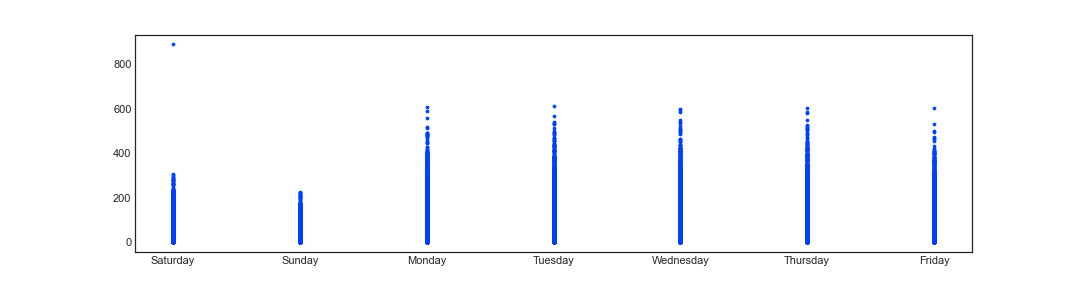

In [128]:
flatiron_turnstile_summary = turnstile_station[turnstile_station['STATION'].str.contains('23 ST')]
plt.figure(figsize=(15,4))
plt.scatter( x=flatiron_turnstile_summary['Day_of_week'], y=flatiron_turnstile_summary['People_per_hour'], marker='.', s=(30,))


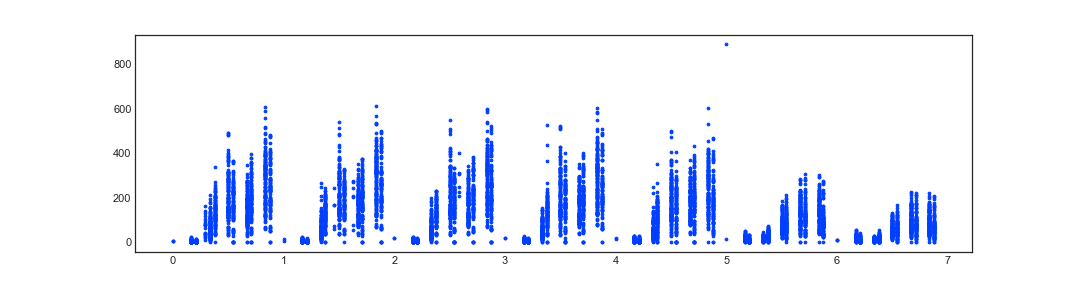

In [129]:
plt.figure(figsize=(15,4))
plt.scatter( x=flatiron_turnstile_summary['Day_hour'], y=flatiron_turnstile_summary['People_per_hour'], marker='.', s=(30,))


In [130]:
station_level = turnstile_station.groupby(['STATION','LINENAME'])[['income','People_per_hour','GTFS Latitude','GTFS Longitude']].agg('mean').reset_index().sort_values(('income'),ascending=False)

station_level.sort_values(by=['income'],ascending=False)

# we know several of our top stations are connected. lets collapse / remove those (i.e. WTC, Etc.)
stations_rm_wtc = station_level[(station_level['STATION'] == ('CITY HALL')) |
                                (station_level['STATION']==('CHAMBERS ST')) |
                                (station_level['STATION']==('CORTLANDT ST')) |
                                (station_level['STATION']==('WTC-CORTLANDT')) |
                                (station_level['STATION']==('HUNTERS PT AV')) |
                                (station_level['STATION']==('21 ST')) |
                                (station_level['STATION']==('WHITEHALL S-FRY')) |
                                (station_level['STATION']==('SOUTH FERRY'))
                               ].index

stations_rm = station_level.drop(stations_rm_wtc)

stations_top10inc = stations_rm.nlargest(15,['income'])
stations_top3inc= stations_rm.nlargest(3,['income'])
stations_top3inc.shape

(3, 6)

In [131]:
station_level

,STATION,LINENAME,income,People_per_hour,GTFS Latitude,GTFS Longitude
474,WTC-CORTLANDT,1,216037.0,41.425182,40.711835,-74.012188
259,CORTLANDT ST,RNW,216037.0,45.914367,40.712603,-74.009552
473,WORLD TRADE CTR,ACE23,216037.0,80.177961,40.712603,-74.009551
251,CITY HALL,NRW,216037.0,41.431866,40.713282,-74.006978
243,CHAMBERS ST,ACE23,216037.0,75.461227,40.712603,-74.009551
...,...,...,...,...,...,...
421,RIT-ROOSEVELT,R,NaN,42.213182,NaN,NaN
444,THIRTY ST,1,NaN,55.630117,NaN,NaN
445,THIRTY THIRD ST,1,NaN,112.664622,NaN,NaN
451,TWENTY THIRD ST,1,NaN,93.859858,NaN,NaN


In [132]:
stations_top10inc.head(15)

,STATION,LINENAME,income,People_per_hour,GTFS Latitude,GTFS Longitude
473,WORLD TRADE CTR,ACE23,216037.0,80.177961,40.712603,-74.009551
398,PARK PLACE,23ACE,216037.0,60.849300,40.712603,-74.009551
130,66 ST-LINCOLN,1,170630.0,107.693487,40.773440,-73.982209
164,96 ST,123,168667.0,154.579224,40.793919,-73.972323
157,86 ST,BC,168667.0,69.112239,40.785868,-73.968916
3,103 ST,BC,168667.0,114.353571,40.796092,-73.961454
155,86 ST,1,168667.0,112.844533,40.788644,-73.976218
166,96 ST,BC,168667.0,95.868284,40.791642,-73.964696
217,BOWLING GREEN,45,129574.0,91.926486,40.704817,-74.014065
458,VERNON-JACKSON,7,125871.0,96.232785,40.742626,-73.953581


In [133]:
stations_top10inc.columns

Index(['STATION', 'LINENAME', 'income', 'People_per_hour', 'GTFS Latitude',
       'GTFS Longitude'],
      dtype='object')

In [267]:
turnstile_station.head()

,STATION,LINENAME,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income
1,59 ST,NQR456W,2019-04-27 04:00:00,Saturday,5,4,5.166667,6.75,40.762593,-73.967612,112269.0
2,59 ST,NQR456W,2019-04-27 08:00:00,Saturday,5,8,5.333333,14.50,40.762593,-73.967612,112269.0
3,59 ST,NQR456W,2019-04-27 12:00:00,Saturday,5,12,5.500000,44.00,40.762593,-73.967612,112269.0
4,59 ST,NQR456W,2019-04-27 16:00:00,Saturday,5,16,5.666667,82.00,40.762593,-73.967612,112269.0
5,59 ST,NQR456W,2019-04-27 20:00:00,Saturday,5,20,5.833333,82.25,40.762593,-73.967612,112269.0


In [135]:
stations_top10inc_turnstile = turnstile_station.merge(stations_top10inc[['STATION', 'LINENAME','income']], how='inner', on=['STATION', 'LINENAME'])
#turnstile_station.drop(columns=["Stop Name"], inplace=True)
stations_top10inc_turnstile.head(3)

,STATION,LINENAME,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income_x,income_y
0,RECTOR ST,NRW,2019-04-27 04:00:00,Saturday,5,4,5.166667,3.00,40.70722,-74.013342,119274.0,119274.0
1,RECTOR ST,NRW,2019-04-27 08:00:00,Saturday,5,8,5.333333,12.75,40.70722,-74.013342,119274.0,119274.0
2,RECTOR ST,NRW,2019-04-27 12:00:00,Saturday,5,12,5.500000,41.25,40.70722,-74.013342,119274.0,119274.0


In [136]:
stations_top3inc_turnstile = turnstile_station.merge(stations_top3inc[['STATION', 'LINENAME','income']], on=['STATION', 'LINENAME'],how="inner")
#turnstile_station.drop(columns=["Stop Name"], inplace=True)
stations_top3inc_turnstile.head(3)
stations_top3inc_names = ["World Trade CTR", "Park Place", "Lincoln Center"]


In [137]:
# union_sq = turnstile_station[turnstile_station['STATION'].str.contains('14 ST-UNION SQ')]

wtc        = stations_top3inc_turnstile[stations_top3inc_turnstile['STATION'].str.contains("WORLD TRADE CTR")]
park_place = stations_top3inc_turnstile[stations_top3inc_turnstile['STATION'].str.contains("PARK PLACE")]
lincoln_center   = stations_top3inc_turnstile[stations_top3inc_turnstile['STATION'].str.contains('LINCOLN')]

top3_stations_list = [wtc, park_place, lincoln_center]

station_list = list([ stations_top3inc_turnstile[stations_top3inc_turnstile['STATION']==stations_top3inc.iloc[R,:]["STATION"]] for R in range(stations_top3inc.shape[0]) ])
                                                                                                                                                                                                                                                                                 
station_list[2]

,STATION,LINENAME,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income_x,income_y
2828,66 ST-LINCOLN,1,2019-04-27 05:00:00,Saturday,5,5,5.208333,16.000000,40.77344,-73.982209,170630.0,170630.0
2829,66 ST-LINCOLN,1,2019-04-27 09:00:00,Saturday,5,9,5.375000,39.250000,40.77344,-73.982209,170630.0,170630.0
2830,66 ST-LINCOLN,1,2019-04-27 13:00:00,Saturday,5,13,5.541667,120.000000,40.77344,-73.982209,170630.0,170630.0
2831,66 ST-LINCOLN,1,2019-04-27 17:00:00,Saturday,5,17,5.708333,163.500000,40.77344,-73.982209,170630.0,170630.0
2832,66 ST-LINCOLN,1,2019-04-27 21:00:00,Saturday,5,21,5.875000,134.500000,40.77344,-73.982209,170630.0,170630.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5172,66 ST-LINCOLN,1,2019-05-24 08:36:45,Friday,4,8,4.333333,47.666667,40.77344,-73.982209,170630.0,170630.0
5173,66 ST-LINCOLN,1,2019-05-24 09:00:00,Friday,4,9,4.375000,24.000000,40.77344,-73.982209,170630.0,170630.0
5174,66 ST-LINCOLN,1,2019-05-24 13:00:00,Friday,4,13,4.541667,29.000000,40.77344,-73.982209,170630.0,170630.0
5175,66 ST-LINCOLN,1,2019-05-24 17:00:00,Friday,4,17,4.708333,48.500000,40.77344,-73.982209,170630.0,170630.0


In [138]:
new_colors_ = dict({0:'darkviolet', 1:'tomato', 2: 'mediumturquoise', 3: 'yellowgreen'})

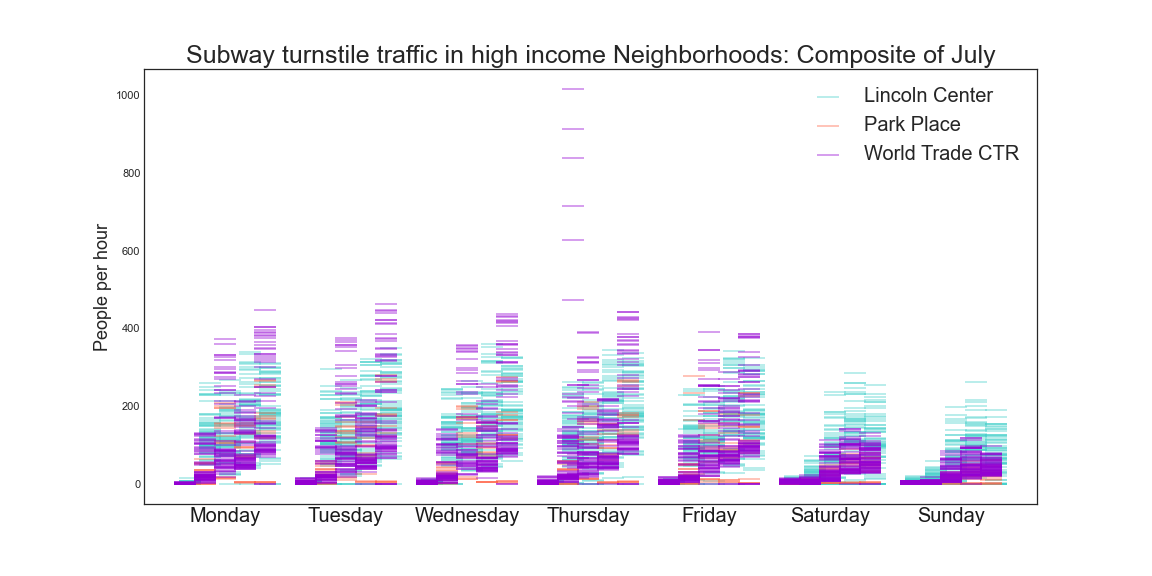

In [139]:
plt.figure(figsize=(16,8))                                                  

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5
#plt.ylim([0, 1000])

plt.title('Subway turnstile traffic in high income Neighborhoods: Composite of July', fontsize='25')
plt.ylabel('People per hour', fontsize='18')

labels = stations_top3inc_names

station=2
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='_', s=(size_,),  alpha=alpha_, color=new_colors_[station], label=labels[station])
station=1
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='_', s=(size_,), alpha=alpha_, color=new_colors_[station], label=labels[station])
station=0
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[0]['People_per_hour'], marker='_', s=(size_,),  alpha=alpha_, color=new_colors_[station], label=labels[station])

plt.legend(fontsize=20)


plt.savefig('Day_hourly_turnstile_fluctuation_at_Highest_Income.svg',transparent=True)


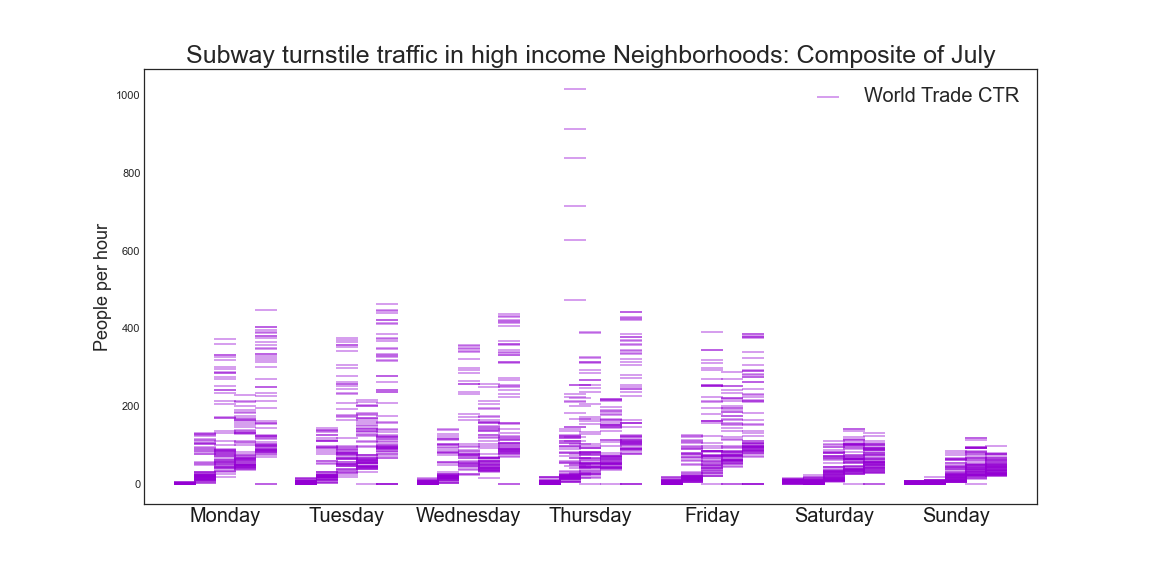

In [140]:
plt.figure(figsize=(16,8))                                                  

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5
#plt.ylim([0, 1000])

plt.title('Subway turnstile traffic in high income Neighborhoods: Composite of July', fontsize='25')
plt.ylabel('People per hour', fontsize='18')


labels = stations_top3inc_names

station=0
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='_', s=(size_,),  alpha=alpha_, color=new_colors_[station], label=labels[station])

plt.legend(fontsize=20)



plt.savefig('Day_hourly_turnstile_fluctuation_at_lincoln_ctr.svg',transparent=True)

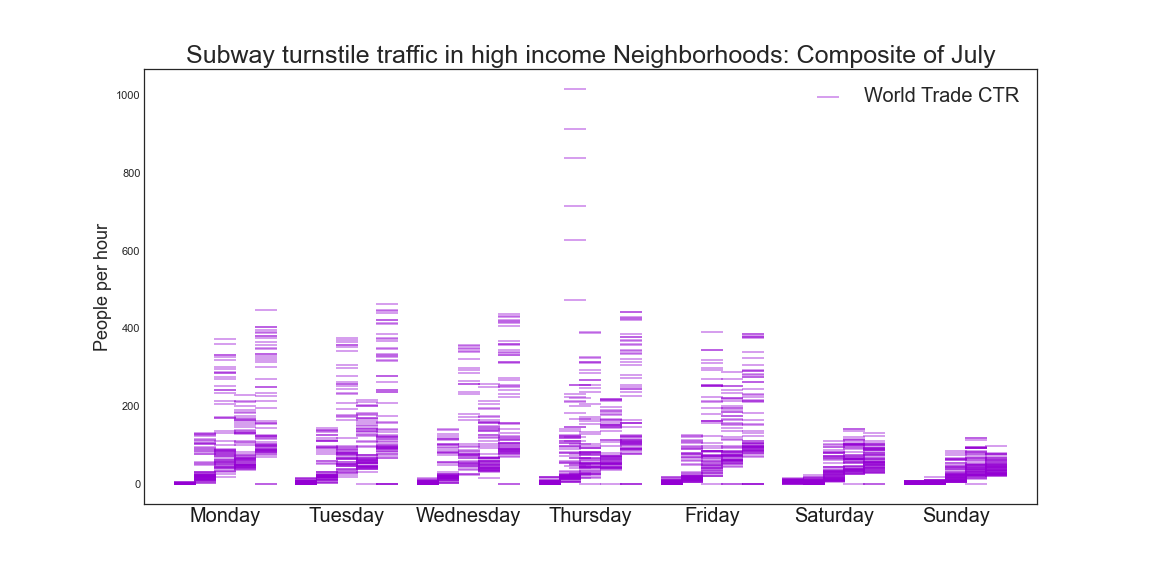

In [141]:
plt.figure(figsize=(16,8))                                                  

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5
#plt.ylim([0, 1000])

plt.title('Subway turnstile traffic in high income Neighborhoods: Composite of July', fontsize='25')
plt.ylabel('People per hour', fontsize='18')


labels = stations_top3inc_names

station=0
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='_', s=(size_,),  alpha=alpha_, color=new_colors_[station], label=labels[station])

plt.legend(fontsize=20)

plt.savefig('Day_hourly_turnstile_fluctuation_at_wtc.svg',transparent=True)

In [142]:
top3_stations_list[2].head()

,STATION,LINENAME,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income_x,income_y
2828,66 ST-LINCOLN,1,2019-04-27 05:00:00,Saturday,5,5,5.208333,16.00,40.77344,-73.982209,170630.0,170630.0
2829,66 ST-LINCOLN,1,2019-04-27 09:00:00,Saturday,5,9,5.375000,39.25,40.77344,-73.982209,170630.0,170630.0
2830,66 ST-LINCOLN,1,2019-04-27 13:00:00,Saturday,5,13,5.541667,120.00,40.77344,-73.982209,170630.0,170630.0
2831,66 ST-LINCOLN,1,2019-04-27 17:00:00,Saturday,5,17,5.708333,163.50,40.77344,-73.982209,170630.0,170630.0
2832,66 ST-LINCOLN,1,2019-04-27 21:00:00,Saturday,5,21,5.875000,134.50,40.77344,-73.982209,170630.0,170630.0


In [143]:
High_income_stations_avg_pp_day_hour = [station.groupby(['Day_hour']).agg({'People_per_hour': ['mean']}).reset_index() for station in top3_stations_list]
High_income_stations_avg_pp_hour = [station.groupby(['Hour']).agg({'People_per_hour': ['mean']}).reset_index() for station in top3_stations_list]
High_income_stations_avg_pp_day = [station.groupby(['Day_num']).agg({'People_per_hour': ['mean']}).reset_index() for station in top3_stations_list]
High_income_stations_avg_pp_day_hour[1].columns

MultiIndex([(       'Day_hour',     ''),
            ('People_per_hour', 'mean')],
           )

In [144]:
High_income_stations_avg_pp_day_hour[1].head(5)

,Day_hour,People_per_hour
,,mean
0,0.166667,1.982143
1,0.333333,28.562500
2,0.500000,119.750000
3,0.666667,80.125000
4,0.833333,141.609375


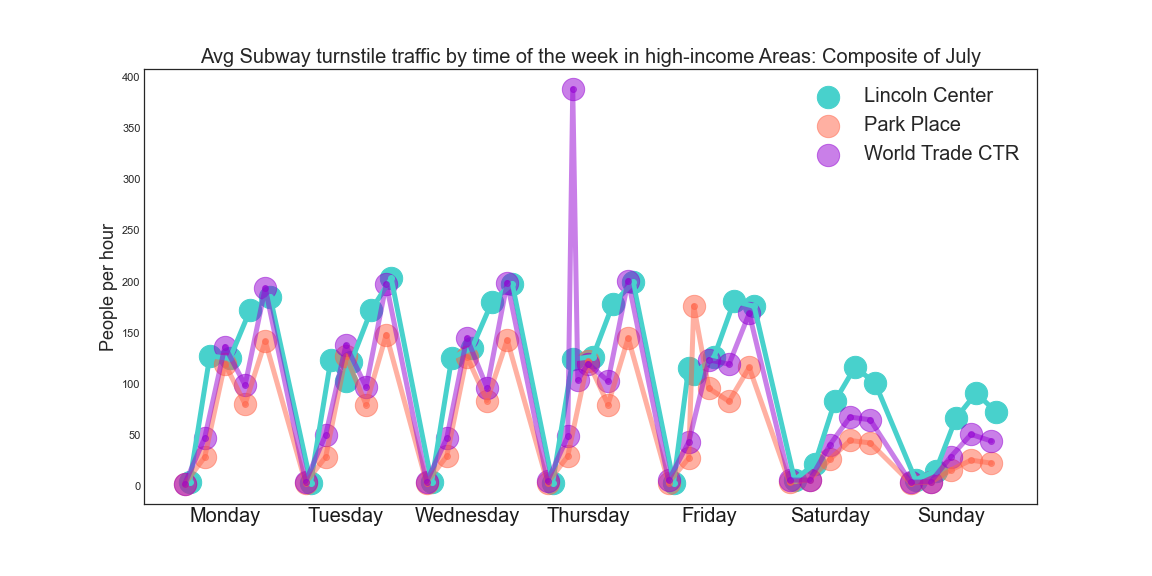

<Figure size 2880x720 with 0 Axes>

In [145]:
# High_income_stations_avg_pp_day_hour[0].head(10)
station_list= High_income_stations_avg_pp_day_hour

plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5
#plt.ylim([0, 450])

plt.title('Avg Subway turnstile traffic by time of the week in high-income Areas: Composite of July', fontsize='20')

plt.ylabel('People per hour', fontsize='18')

station=2
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=new_colors_[station], alpha=alpha_*2, label=labels[station])
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o', color=new_colors_[station], alpha=alpha_*2, lw='5')

station=1
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=new_colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o', color=new_colors_[station], alpha=alpha_, lw='5')

station=0
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=new_colors_[station], alpha=alpha_, label=labels[station])
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o', color=new_colors_[station], alpha=alpha_, lw='5')

plt.legend(fontsize=20)
plt.show()
#plt.savefig('Avg_Day_hourly_turnstile_fluctuation_in_high_income_areas.svg',transparent=True)
plt.savefig('Avg_Day_hourly_test.svg',transparent=True)
# station_list[1].head()

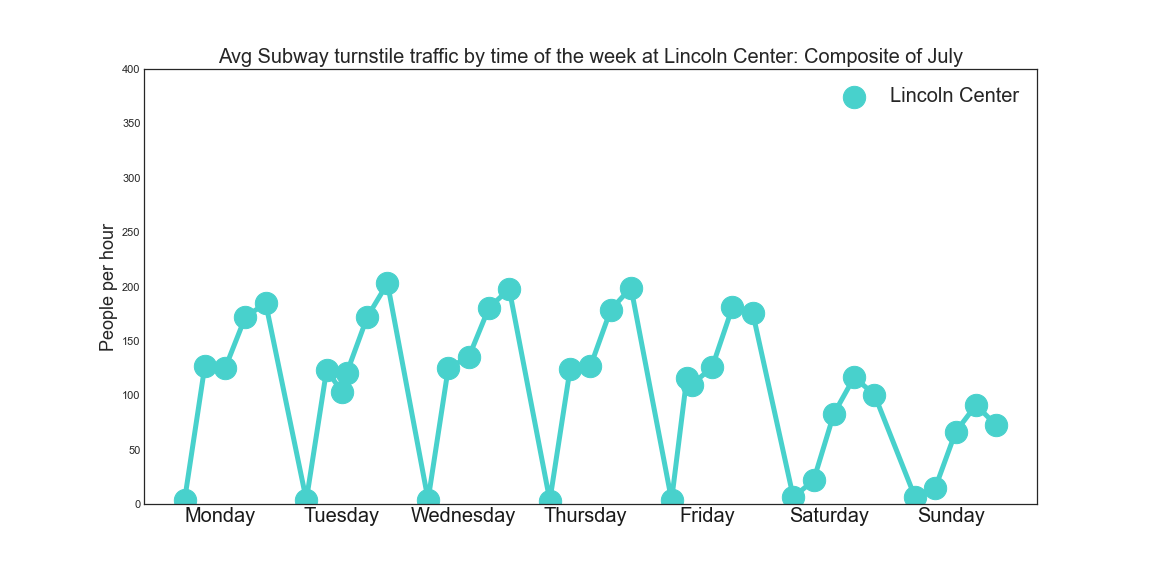

<Figure size 2880x720 with 0 Axes>

In [146]:
plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5
plt.ylim([0.0, 400.0])
plt.ylabel('People per hour', fontsize='18')

plt.title('Avg Subway turnstile traffic by time of the week at Lincoln Center: Composite of July', fontsize='20')


station=2
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=new_colors_[station], alpha=alpha_*2, label=labels[station])
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o', color=new_colors_[station], alpha=alpha_*2, lw='5')

plt.legend(fontsize=20)
plt.show()
plt.savefig('Avg_Day_hourly_turnstile_fluctuation_at_Lincoln_Center.svg',transparent=True)
plt.savefig('Avg_Day_hourly_turnstile_flux_LincCtr.svg',transparent=True)

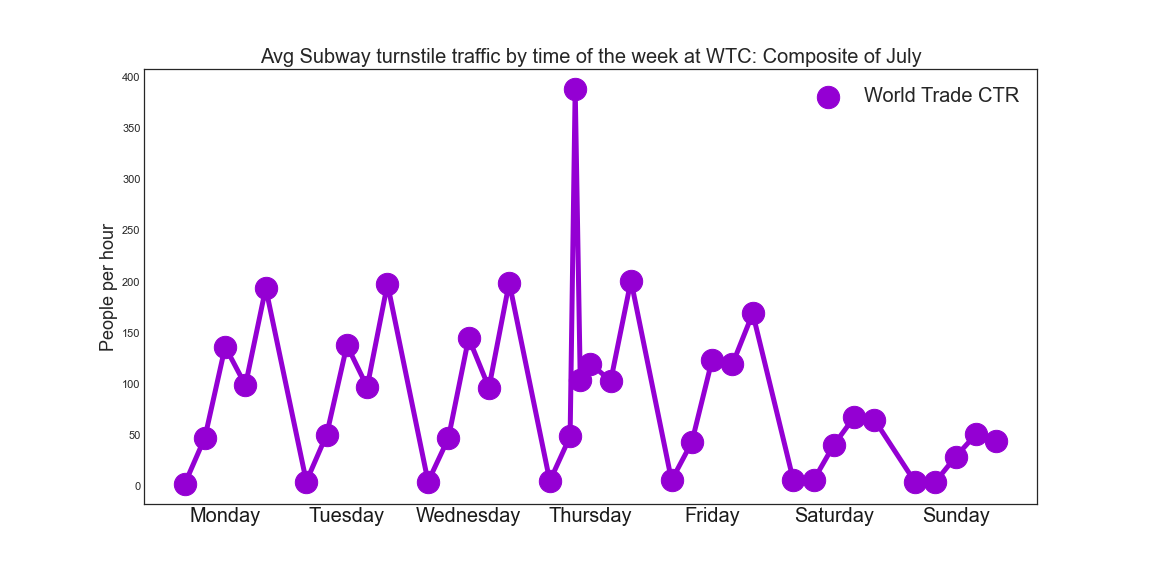

<Figure size 2880x720 with 0 Axes>

In [147]:
plt.figure(figsize=(16,8))

#station_list = turnstile_station['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '20', color='k');
size_ = 500
alpha_ = .5
#plt.ylim([0, 300])
plt.ylabel('People per hour', fontsize='18')

plt.title('Avg Subway turnstile traffic by time of the week at WTC: Composite of July', fontsize='20')


station=0
plt.scatter( x=station_list[station]['Day_hour'], y=station_list[station]['People_per_hour'], marker='o', s=(size_,), color=new_colors_[station], alpha=alpha_*2, label=labels[station])
plt.plot( station_list[station]['Day_hour'], station_list[station]['People_per_hour'], marker='o', color=new_colors_[station], alpha=alpha_*2, lw='5')

plt.legend(fontsize=20)
plt.show()
plt.savefig('Avg_Day_hourly_turnstile_fluctuation_at_Lincoln_Center.svg',transparent=True)
plt.savefig('Avg_Day_hourly_turnstile_flux_WTC.svg',transparent=True)

## This dataframe view `turnstile_summary` would be a good one with which to merge income data.  It would also be a good one to make a lat-long scatterplot to indicate traffic.  

Merge (join) the turnstile and stations dataframes.  We probably have too many columms here and should pare down.

#### This section is code by **Chris Chan**, which visualizes income data by latitude and longitude coordinates

## ----------- CC - Geo location and Income visuals --------------

Keep in mind, as noted earlier, the data needs to be at the unique station level in order for this to work properly.
The merge of turnstile to station included a middle step with a xwalk. This is not coming out 1:1 in the merge so we 
need to fix the merge first then provide the graphs.

In [149]:
turnstile_station.head()

,STATION,LINENAME,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income
1,59 ST,NQR456W,2019-04-27 04:00:00,Saturday,5,4,5.166667,6.75,40.762593,-73.967612,112269.0
2,59 ST,NQR456W,2019-04-27 08:00:00,Saturday,5,8,5.333333,14.50,40.762593,-73.967612,112269.0
3,59 ST,NQR456W,2019-04-27 12:00:00,Saturday,5,12,5.500000,44.00,40.762593,-73.967612,112269.0
4,59 ST,NQR456W,2019-04-27 16:00:00,Saturday,5,16,5.666667,82.00,40.762593,-73.967612,112269.0
5,59 ST,NQR456W,2019-04-27 20:00:00,Saturday,5,20,5.833333,82.25,40.762593,-73.967612,112269.0


<AxesSubplot:xlabel='GTFS Longitude', ylabel='GTFS Latitude'>

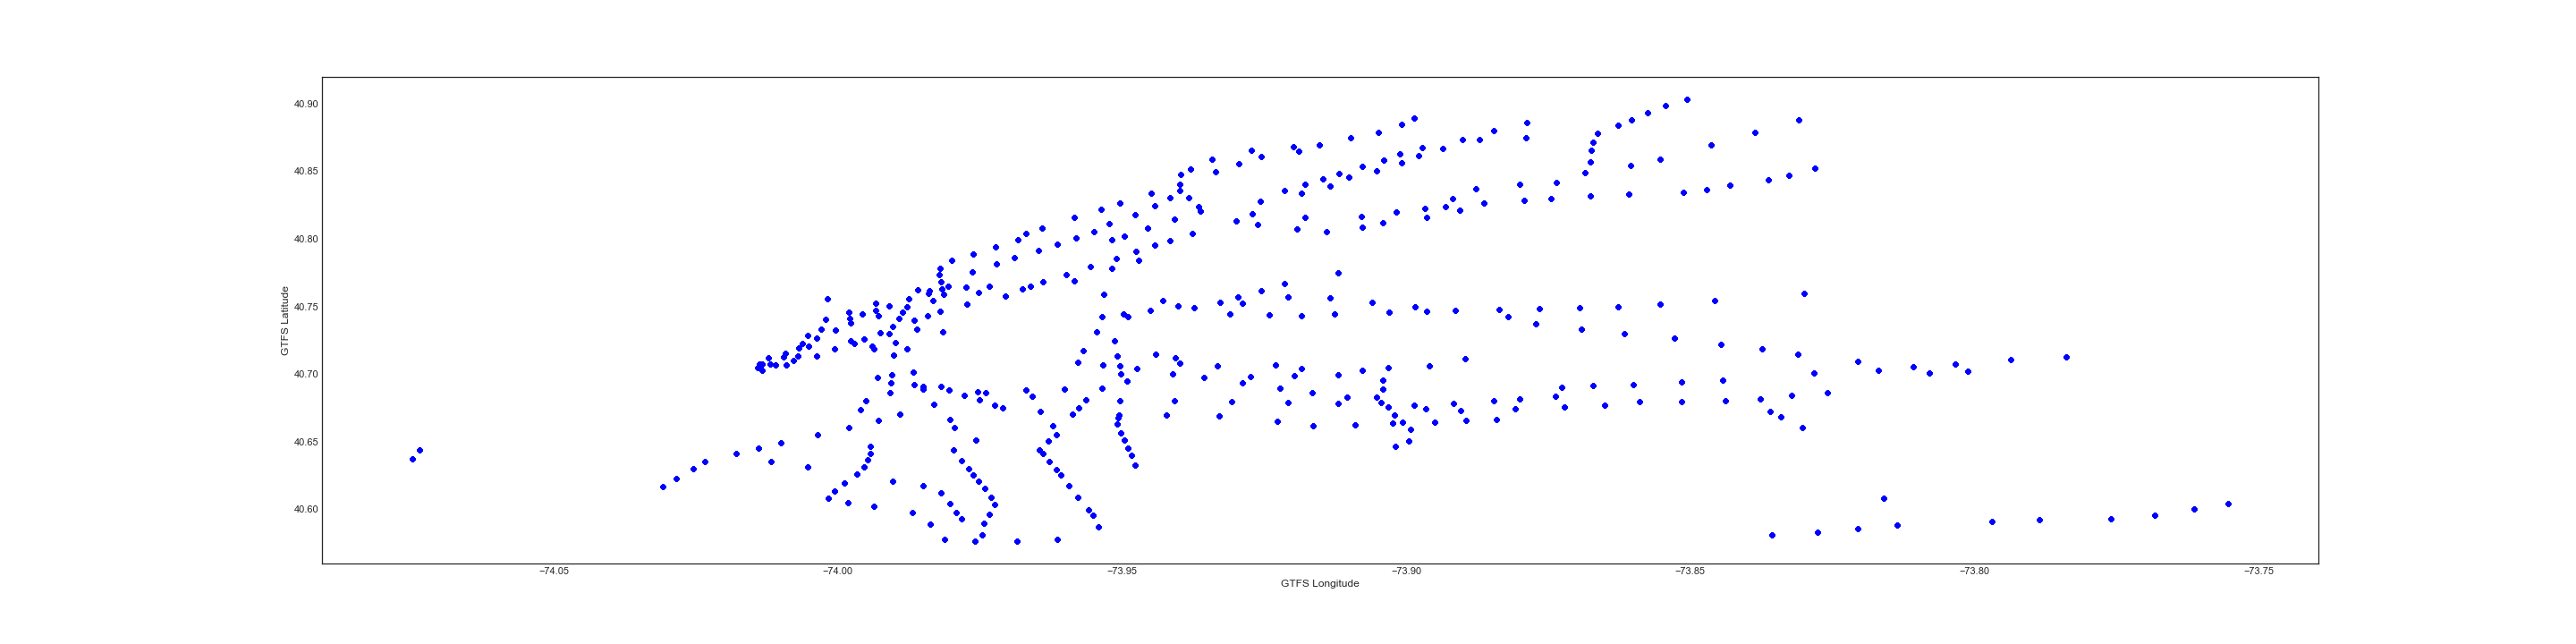

In [150]:
# Very basic plot of lat/long
turnstile_station.plot(kind="scatter", x="GTFS Longitude", y="GTFS Latitude", alpha=0.1, color="blue")
#save_fig("basic lat/lon")

### CC - This is the lat/long graph (stations as bubbles) and income as color
. Need to fix merge to get data at a unique station level
. Can make something more complex by adding map onto the graph

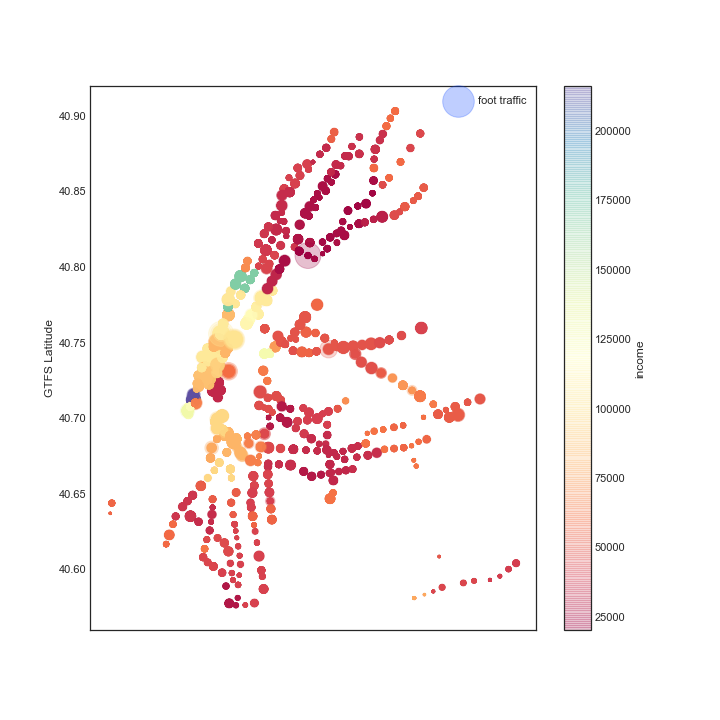

In [151]:
turnstile_station.plot(kind="scatter", x="GTFS Longitude", y="GTFS Latitude",
    s=turnstile_station['People_per_hour']/5, label="foot traffic",
    c="income", cmap=plt.get_cmap("Spectral"),
    colorbar=True, alpha=0.25, figsize=(10,10),
    
                       
)
plt.legend()
#save_fig("Plot of Traffic and Income")
plt.show()

# Top Stations by Income

In [152]:
station_level = turnstile_station.groupby(['STATION'])[['income']].agg('mean').reset_index().sort_values(('income'),ascending=False)

In [153]:
station_level.sort_values(by=['income'],ascending=False)

,STATION,income
191,CORTLANDT ST,216037.0
179,CHAMBERS ST,216037.0
184,CITY HALL,216037.0
375,WTC-CORTLANDT,216037.0
374,WORLD TRADE CTR,216037.0
...,...,...
328,RIT-MANHATTAN,NaN
329,RIT-ROOSEVELT,NaN
350,THIRTY ST,NaN
351,THIRTY THIRD ST,NaN


## Top 20 Stations by Income

In [154]:
station_level.head(20)

,STATION,income
191,CORTLANDT ST,216037.000000
375,WTC-CORTLANDT,216037.000000
374,WORLD TRADE CTR,216037.000000
179,CHAMBERS ST,216037.000000
184,CITY HALL,216037.000000
91,66 ST-LINCOLN,170630.000000
310,PARK PLACE,148913.842105
115,96 ST,143798.090909
158,BOWLING GREEN,129574.000000
361,VERNON-JACKSON,125871.000000


## ------------ CC - END income geo graphs ------------

In [292]:
## IGNORE THIS!!

#turnstile_station = df.merge(stations, left_on="STATION", right_on="Stop Name")

# turnstile_station = turnstile_summary.merge(stations[['income', 'Stop Name']], left_on="STATION", right_on="Stop Name")
# turnstile_station.drop(columns=["Stop Name"], inplace=True)
# turnstile_station

## Early-stage note from JBM to teammates
For this to be useful regarding income levels in neighborhoods (which will probably exists by zip code), 

we'd have to merge this station we'd have to use library that gets zip code from lat and longitude

I believe the one to use is probably geopy: 
[geopy](https://geopy.readthedocs.io/en/stable/)

These might or not be helpful:

[income by zip](https://www.incomebyzipcode.com/newyork)

[open data nyc](https://opendata.cityofnewyork.us/)    

# The busiest subway stations. 
This code was supplied by teemmate **Humza Kahn**.

### Note from Josh to Humza: I think the code below here should be re-oriented to draw instead from `turnstile_summary` using its column `People_per_hour`

In [269]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Traffic_running_total
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,00:00:00,REGULAR,7035249,2384833,2019-04-27 00:00:00,9420082
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,04:00:00,REGULAR,7035269,2384840,2019-04-27 04:00:00,9420109
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,08:00:00,REGULAR,7035292,2384875,2019-04-27 08:00:00,9420167
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,12:00:00,REGULAR,7035392,2384951,2019-04-27 12:00:00,9420343
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,16:00:00,REGULAR,7035651,2385020,2019-04-27 16:00:00,9420671


In [270]:
#Check for abnormalities. Less than zero are changed to positive and greater than the max are reset to 0
def daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        return 0
    return counter

In [271]:
#sort "ENTRIES" by including "Datetime"
(df.groupby(["C/A", "UNIT", "SCP", "STATION", "Datetime"])
    .ENTRIES.count()
    .reset_index()
    .sort_values("ENTRIES", ascending=False));

In [272]:
#Sort ENTRIES and keep the ending value of the day
df_daily = df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"])\
                .ENTRIES.first().reset_index().copy()

In [273]:
df_4hourly = df.groupby(["C/A", "UNIT", "SCP", "STATION", "Datetime"])\
                .ENTRIES.first().reset_index().copy()

In [274]:
df_4hourly.head()

,C/A,UNIT,SCP,STATION,Datetime,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-04-27 00:00:00,7035249
1,A002,R051,02-00-00,59 ST,2019-04-27 04:00:00,7035269
2,A002,R051,02-00-00,59 ST,2019-04-27 08:00:00,7035292
3,A002,R051,02-00-00,59 ST,2019-04-27 12:00:00,7035392
4,A002,R051,02-00-00,59 ST,2019-04-27 16:00:00,7035651


In [275]:
#Grab the previous row's DATE and ENTRIES and pull into current column for all columns.
df_daily[["PREV_DATE", "PREV_ENTRIES"]] = (df_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]\
                                          .transform(lambda grp: grp.shift(1)));

<ipython-input-275-60c4191346a3>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_daily[["PREV_DATE", "PREV_ENTRIES"]] = (df_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]\


In [276]:
df_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,04/27/2019,7035249,NaN,NaN
1,A002,R051,02-00-00,59 ST,04/28/2019,7036100,04/27/2019,7035249.0
2,A002,R051,02-00-00,59 ST,04/29/2019,7036746,04/28/2019,7036100.0
3,A002,R051,02-00-00,59 ST,04/30/2019,7038242,04/29/2019,7036746.0
4,A002,R051,02-00-00,59 ST,05/01/2019,7039729,04/30/2019,7038242.0


In [277]:
#Use daily_counts function 
df_daily["DAILY_ENTRIES"] = df_daily.apply(daily_counts, axis=1, max_counter=1000000);

In [278]:
df_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
0,A002,R051,02-00-00,59 ST,04/27/2019,7035249,NaN,NaN,NaN
1,A002,R051,02-00-00,59 ST,04/28/2019,7036100,04/27/2019,7035249.0,851.0
2,A002,R051,02-00-00,59 ST,04/29/2019,7036746,04/28/2019,7036100.0,646.0
3,A002,R051,02-00-00,59 ST,04/30/2019,7038242,04/29/2019,7036746.0,1496.0
4,A002,R051,02-00-00,59 ST,05/01/2019,7039729,04/30/2019,7038242.0,1487.0


In [279]:
#Dataframe for STATION and DATE and sum on DAILY ENTRIES.

df_daily_stations = df_daily.groupby(['STATION', 'DATE'])['DAILY_ENTRIES'].sum().reset_index().sort_values(['DATE'])

In [280]:
df_median = df_daily_stations.groupby(['STATION'])['DAILY_ENTRIES'].agg(['median']).reset_index().sort_values(['median'], ascending=False)
df_median_10 = df_median[:10]

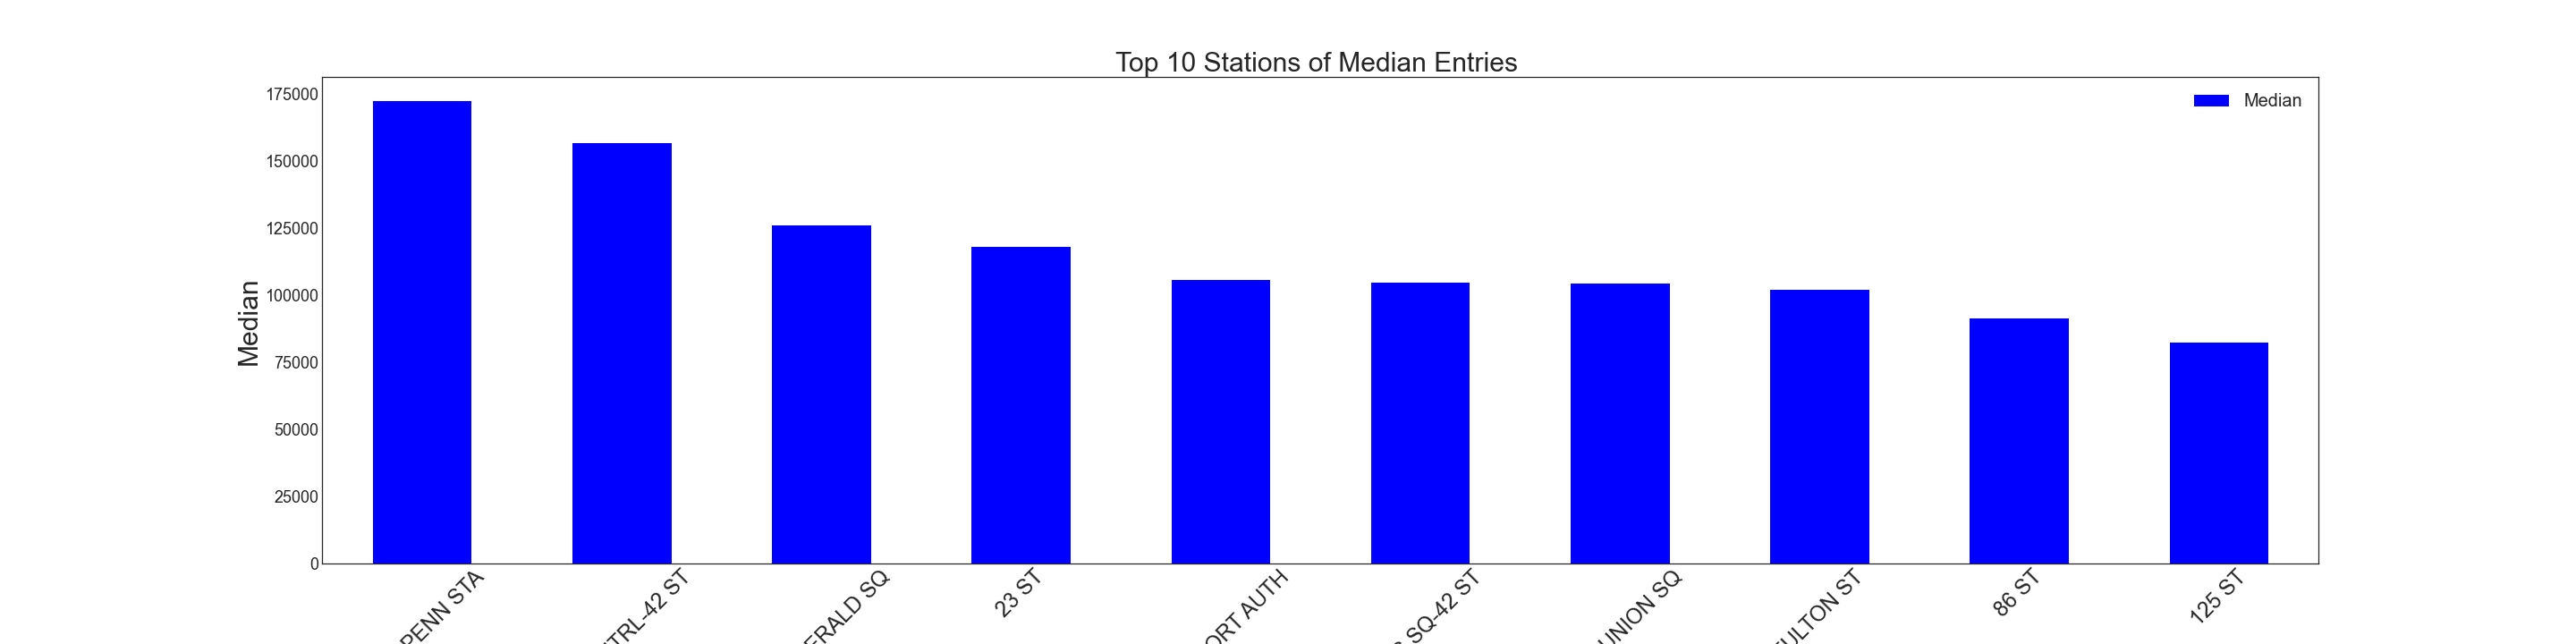

In [281]:
#top ten stations bar plot

df_median_10.plot.bar(x='STATION',y='median',color='blue')
plt.xlabel('Stations', fontsize=30)
plt.ylabel('Median', fontsize=30)
plt.title("Top 10 Stations of Median Entries ", fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=18)
plt.xticks(rotation=45)
plt.legend(["Median"], prop={"size":20})

plt.show()

In [282]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Traffic_running_total
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,00:00:00,REGULAR,7035249,2384833,2019-04-27 00:00:00,9420082
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,04:00:00,REGULAR,7035269,2384840,2019-04-27 04:00:00,9420109
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,08:00:00,REGULAR,7035292,2384875,2019-04-27 08:00:00,9420167
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,12:00:00,REGULAR,7035392,2384951,2019-04-27 12:00:00,9420343
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,16:00:00,REGULAR,7035651,2385020,2019-04-27 16:00:00,9420671


In [283]:
df_median = df.groupby('STATION')['ENTRIES'].sum().sort_values(ascending=False)
df_median.head(10)

STATION
42 ST-PORT AUTH    1342803305655
125 ST             1125394276897
TIMES SQ-42 ST     1075169161861
3 AV-149 ST         871050714699
CHAMBERS ST         851603937108
104 ST              816258296659
34 ST-HERALD SQ     792675667461
14 ST               772005743126
FULTON ST           757707751067
23 ST               755324343091
Name: ENTRIES, dtype: int64

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


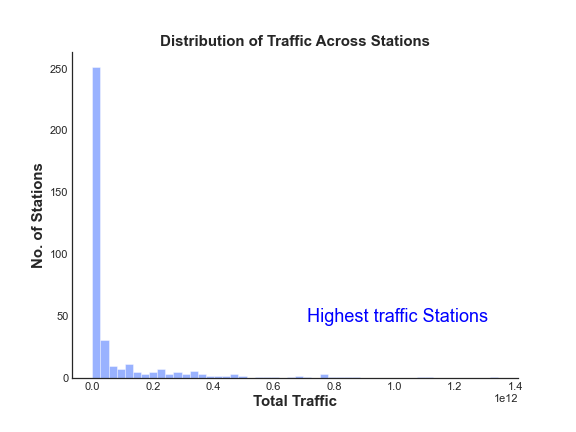

In [284]:
fig1 = plt.figure(figsize=[8,6])
ax1 = sns.distplot(df_median,bins=50,kde=False)
#plt.xlim([0,410000])
plt.ylabel('No. of Stations',fontsize=15, weight='bold')
plt.xlabel('Total Traffic', fontsize=15, weight='bold')
ax1.annotate('Highest traffic Stations', xy=(0.73, 0.08), xytext=(0.73, 0.16), xycoords='axes fraction', 
            fontsize=18, ha='center', va='bottom', arrowprops=dict(arrowstyle='-[, widthB=9.0, lengthB=1', lw=8.0),color='blue')                            
                            
plt.title('Distribution of Traffic Across Stations',fontsize=15,weight='bold')
sns.despine()

plt.savefig('histplot.png',transparent=True, bbox_inches='tight')

In [285]:
#Gives top 5
df.groupby(['LINENAME', 'STATION']).sum().sort_values(by='ENTRIES',ascending=False).head(10)

,,ENTRIES,EXITS,Traffic_running_total
LINENAME,STATION,,,
ACENQRS1237W,42 ST-PORT AUTH,1325100766251,1087383399661,2412484165912
1237ACENQRSW,TIMES SQ-42 ST,1050107602568,572042830342,1622150432910
25,3 AV-149 ST,871050714699,573974218369,1445024933068
BDFMNQRW,34 ST-HERALD SQ,792675667461,993997895389,1786673562850
4,183 ST,688797769222,440331418268,1129129187490
123,72 ST,595692069534,794986496814,1390678566348
ACJZ2345,FULTON ST,566891838239,371440694638,938332532877
MR,ELMHURST AV,542939140010,785995739092,1328934879102
JZ,104 ST,530523541168,426588183018,957111724186
